# Marathon Predictor

### Import packages ###

In [303]:
import pandas as pd
import numpy as np
import math
import time
import os
import requests
# import scipy.stats as stats
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import re
import ssl

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText

from sklearn.model_selection import train_test_split


# Ignore SSL certificate errors. Need to also have 'context=ctx' as urlopen parameter.
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib widget


### Set Functions ###

convert_time, get_weather, calc_humidity

In [156]:
# Set of functions and variables we'll use for cleaning and calculating data

# Function to convert times
def convert_time(time):
    try:
        return pd.to_datetime(time)
    except:
        return np.nan

# NCEI Global Summary of the Day:
# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516

# Data types: https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
# TEMP - Mean temperature (.1 Fahrenheit)
# DEWP - Mean dew point (.1 Fahrenheit)
# SLP - Mean sea level pressure (.1 mb)
# STP - Mean station pressure (.1 mb)
# VISIB - Mean visibility (.1 miles)
# WDSP – Mean wind speed (.1 knots)
# MXSPD - Maximum sustained wind speed (.1 knots)
# GUST - Maximum wind gust (.1 knots)
# MAX - Maximum temperature (.1 Fahrenheit)
# MIN - Minimum temperature (.1 Fahrenheit)
# PRCP - Precipitation amount (.01 inches)
# SNDP - Snow depth (.1 inches)
# FRSHTT – Indicator for occurrence of:
#                               Fog
#                               Rain or Drizzle
#                               Snow or Ice Pellets
#                               Hail
#                               Thunder
#                               Tornado/Funnel Cloud

# Find Stations: https://www.ncei.noaa.gov/maps/daily/?layers=0001
# Generally used closest airport since data usually covers full range of years

station_ids = {'Boston':['72509014739'],
               'Carmel':['72491523259','72491599999','72491523245'],
               'Chicago':['72530094846'],
               'Duluth':['72745014913'],
               'Honololu':['91182022521'],
               'Houston':['72244012918','72243012960'],
               'Los Angeles':['72288593197','72288599999','72287493134'],
               'Minneapolis':['72658014922'],
               'Montreal':['71371099999','71612099999','71627099999','71627094792'],
               'New York City':['72503014732', '99999914732'],
               'Orlando':['72205012815'],
               'Ottawa':['71628099999','71627999999'],
               'Philadelphia':['72408013739'],
               'Phoenix':['72278023183'],
               'Portland':['72698024229'],
               'Sacramento':['72483993225','72483999999','72483323206','72483399999'],
               'San Diego':['72290023188'],
               'San Francisco':['72494023234'],
               'Seattle':['72793524234','72793024233'],
               'St. George':['72475423186','72475499999','72092299999','72475593129'],
               'Toronto':['71265099999','71624099999'],
               'Vancouver':['71892099999','71784099999'],
               'Washington':['72405013743'],
               'Berlin':['10382099999'],'London':['3772099999'],'Tokyo':['47662099999']}

weather_cols = ['STATION','DATE','LATITUDE','LONGITUDE','ELEVATION',
                'TEMP','MAX','MIN','PRCP','DEWP',
                'WDSP','SLP','STP','VISIB']

# Function for getting NCEI weather data
def get_weather(date, city):
    try:
        stations = station_ids[city]
        year = date.year
        directory = f'weather_csvs/{city}/'
        if not os.path.exists(directory):
            print(f'Created directory {directory}.')
            os.mkdir(directory)
        # Try multiple station_ids for the same location since ids are occasionally updated
        for station_id in station_ids[city]:
            file_name = f'{station_id}_{year}.csv'
            try:
                try: # Check if file saved locally from previous run
                    temp_df = pd.read_csv(directory+file_name)
                except:
                    url = f'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{station_id}.csv'
                    temp_df = pd.read_csv(url)
                    temp_df.to_csv(f'{directory}{file_name}',index=False)
                    print(f'Retrieved {file_name} online and saved to local drive folder {directory}.')
                    sleeptime = np.random.uniform(1, 2)
                    time.sleep(sleeptime)
                temp_df['DATE'] = pd.to_datetime(temp_df['DATE'], format="%Y-%m-%d")
                weather_data = temp_df[temp_df['DATE']==date]
                weather_data = weather_data[weather_cols].squeeze().tolist()
                break
            except: continue # on to check the next station in this city
            
        temp_df['DATE'] = pd.to_datetime(temp_df['DATE'], format="%Y-%m-%d")
        weather_data = temp_df[temp_df['DATE']==date]
        weather_data = weather_data[weather_cols].squeeze().tolist()
    except: # If function fails, get empty weather data (NCEI records don't go back far enough)
        weather_data = pd.DataFrame(columns = weather_cols,
                                    index = [0]).squeeze().tolist()
        
    return weather_data

# Test get_weather
# get_weather(pd.to_datetime('2011-10-10', format="%Y-%m-%d"), 'Boston')

# Relative humidity calculator
def calc_humidity(temp_f,dewpoint_f):
    # Convert temps from F to C
    T = (temp_f-32)*5/9
    DP = (dewpoint_f-32)*5/9
    
    # Save constants
    a = 17.625
    b = 243.04
    
    # Calculate based on https://bmcnoldy.rsmas.miami.edu/Humidity.html
    RH = 100*(math.exp((a*DP)/(b+DP))/math.exp((a*T)/(b+T)))
    return RH

In [125]:
# Test get_weather
get_weather(pd.to_datetime('2005-05-01', format="%Y-%m-%d"), 'Vancouver')

[71784099999,
 Timestamp('2005-05-01 00:00:00'),
 49.35,
 -123.2,
 168.0,
 54.6,
 66.2,
 46.4,
 0.07,
 49.1,
 1.7,
 1020.8,
 0.5,
 999.9]

### Pull Race Info and Results ###

1. scrape race dates, number of finishers, quantile times
2. save race dates; one csv per city

['Year', 'Date', 'Marathon']

In [345]:
driver.close()

### Parse marathon results with BS4 and Selenium (Includes decile times)

In [3]:
# Dictionary where we'll add a df for each event
events_dfs = {}

In [9]:
# List of initial race IDs used by MarathonGuide.com
init_ids = {#'Boston':'15000417',
        'Chicago':'67001022',
        'New York City':'472001105'
       }

In [10]:
# Scrape race results for all race events.
# Increase time.sleep(x) in appropriate spot(s) if this breaks.

for event, init_id in init_ids.items():
    # Create driver and point to initial url
    init_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={init_id}'
    driver = webdriver.Safari()
    driver.get(init_url)
    sleeptime = np.random.uniform(6, 9)
    time.sleep(sleeptime)
    
    # Find all the event IDs in the 'a' tag hyperlinks. Each corresponds to a year of the event.
    event_ids = sorted(list(set(re.findall(r'MIDD=(\d+)', driver.page_source))), reverse=True)#[:1] # REMOVE this index limiting the years
    
    # Create df for this event. First column is event ID.
    event_df = (pd.DataFrame({'Event ID':event_ids})
                .set_index('Event ID'))
    
    for event_id in event_ids:
        event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={event_id}'
        driver.get(event_url)
        sleeptime = np.random.uniform(6, 9)
        time.sleep(sleeptime)
        
        try:
            # Find the event name, date, city, state, number of finishers, etc.
            event_df.loc[event_id,'Event Name'] = re.findall(
                r'<b>(.+)</b> - Results', driver.page_source)[0]
            event_df.loc[event_id,'Date'] = re.findall(
                r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
            event_df.loc[event_id,['City','State']] = re.findall(
                # r'([\w\-\.\/ ]+), ([A-Z]{2})', page_source)[0]
                r'([^\>]+), ([A-Z]{2})', page_source)[0] # More generalized for compound cities
            event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', driver.page_source)[0]
            event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
            event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', driver.page_source)[0]
        
        # In case the event page is missing some data, only get deciles if we have finisher count
        except:
            print(event_df.loc[event_id])
            if np.isnan(float(event_df.loc[event_id,'Finishers'])): continue
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)
            pass
        
        # Calculate Decile Places
        finishers = float(event_df.loc[event_id,'Finishers'])
        decile_places = [str(int(decile)) for decile in np.linspace(1,finishers,11)]
        event_df.loc[event_id,['D0 Place','D1 Place','D2 Place','D3 Place','D4 Place','D5 Place',
                              'D6 Place','D7 Place','D8 Place','D9 Place', 'D10 Place']
                    ] = decile_places
        
        # Names for cols for decile times we'll iterate over
        decile_cols = ['D0','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
        
        # Find the finish time for each decile
        for finish_place, decile in zip(decile_places,decile_cols): # [0:3] REMOVE these indices to get all deciles
            try:
                # Find the dropdown/Select elements for finisher place range/options
                selector = driver.find_element(by=By.XPATH, value="//select[@name='RaceRange']")
                all_options = selector.find_elements(by=By.TAG_NAME, value="option")
                results_page = int((int(finish_place)+99)/100)
                option = all_options[results_page]
                submit_button = driver.find_element(by=By.XPATH, value="//input[@name='SubmitButton']")

                # Load the results page
                selector.click()
                option.click()
                submit_button.click()
                sleeptime = np.random.uniform(6, 9)
                time.sleep(sleeptime)

                # The results page contains several levels of nested tables.
                # Depending on the particular page, here are possible paths
                try:
                    soup = BeautifulSoup(driver.page_source)
                    table1 = soup.find_all('table')[9]
                    table2 = table1.find_all('table')[3]
                    table3 = table2.find_all('table')[0]
                    table4 = table3.find_all('table')[0]
                    table5 = table4.find_all('table')[0]
                except:
                    soup = BeautifulSoup(driver.page_source)
                    table1 = soup.find_all('table')[11]
                    table2 = table1.find_all('table')[3]
                    table3 = table2.find_all('table')[0]
                    table4 = table3.find_all('table')[0]
                    table5 = table4.find_all('table')[0]

                # Convert the table into pandas df and clean
                page_df = pd.read_html(str(table5))[0].iloc[2:]
                page_df.columns = page_df.iloc[0]
                page_df = page_df.drop(index = 2)
                # Account for different column naming per event
                if 'Net Time' not in page_df.columns:
                    page_df = page_df.rename(columns={'Time':'Net Time'})

                # Get the finish time for the desired finish place and update event_df
                finish_time = (page_df[page_df['OverAllPlace'] == finish_place]
                               .loc[:,'Net Time']
                               .iloc[0])
                event_df.loc[event_id,decile] = finish_time
                
                # Return to event page to prep for next decile
                driver.get(event_url)
                sleeptime = np.random.uniform(6, 9)
                time.sleep(sleeptime)
                
            # If parsing a decile time fails:
            # print data, leave decile time as NaN, and continue to remaining deciles
            except:
                print(event_df.loc[event_id,['Event Name','Date']])
                print(f'    {decile}: {finish_place}\n')
                sleeptime = np.random.uniform(6, 9)
                time.sleep(sleeptime)
                pass
            
                # Return to event page to prep for next decile
                driver.get(event_url)
                sleeptime = np.random.uniform(6, 9)
                time.sleep(sleeptime)
    
    # Add this event_df to the dictionary of events_dfs
    events_dfs[event] = event_df
    # Save the event results to a csv
    directory = 'results_csvs/'
    if not os.path.exists(directory):
        print(f'Directory created: {directory}')
        os.mkdir(directory)

    now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    event_df.to_csv(f'{directory}{event}_{now}.csv',index=True)
    
    driver.close()

KeyboardInterrupt: 

In [ ]:
driver.close()

In [6]:
# Check race results csvs for missing data and try pulling just those rows again

for file in os.listdir("results_csvs"):
    if file.endswith(".csv"):
        print(os.path.join("results_csvs", file))
        
        # Open a df and get the index of all rows with one or more missing cells (NaN)
        event_df = (pd.read_csv(os.path.join("results_csvs", file))
                   .set_index('Event ID'))
        nan_rows = event_df[event_df.isnull().T.any()]
        print(nan_rows.index)
        
        for event_id in nan_rows.index:
            event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={event_id}'
            # Create driver and point to url
            driver = webdriver.Safari()
            driver.get(event_url)
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)

            try:
                # Find the event name, date, city, state, number of finishers, etc.
                event_df.loc[event_id,'Event Name'] = re.findall(
                    r'<b>(.+)</b> - Results', driver.page_source)[0]
                event_df.loc[event_id,'Date'] = re.findall(
                    r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
                event_df.loc[event_id,['City','State']] = re.findall(
                    r'([\w\- ]+), ([A-Z]{2})', driver.page_source)[0]
                event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                    r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', driver.page_source)[0]
                event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                    r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
                event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                    r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', driver.page_source)[0]

            # In case the event page is missing some data, only get deciles if we have finisher count
            except:
                print(event_df.loc[event_id])
                if np.isnan(float(event_df.loc[event_id,'Finishers'])): continue
                sleeptime = np.random.uniform(6, 9)
                time.sleep(sleeptime)
                pass

            # Calculate Decile Places
            finishers = float(event_df.loc[event_id,'Finishers'])
            decile_places = [str(int(decile)) for decile in np.linspace(1,finishers,11)]
            event_df.loc[event_id,['D0 Place','D1 Place','D2 Place','D3 Place','D4 Place','D5 Place',
                                  'D6 Place','D7 Place','D8 Place','D9 Place', 'D10 Place']
                        ] = decile_places

            # Names for cols for decile times we'll iterate over
            decile_cols = ['D0','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']

            # Find the finish time for each decile
            for finish_place, decile in zip(decile_places,decile_cols): # [0:3] REMOVE these indices to get all deciles
                try:
                    # Find the dropdown/Select elements for finisher place range/options
                    selector = driver.find_element(by=By.XPATH, value="//select[@name='RaceRange']")
                    all_options = selector.find_elements(by=By.TAG_NAME, value="option")
                    results_page = int((int(finish_place)+99)/100)
                    option = all_options[results_page]
                    submit_button = driver.find_element(by=By.XPATH, value="//input[@name='SubmitButton']")

                    # Load the results page
                    selector.click()
                    option.click()
                    submit_button.click()
                    sleeptime = np.random.uniform(6, 9)
                    time.sleep(sleeptime)

                    # The results page contains several levels of nested tables.
                    # Depending on the particular page, here are possible paths
                    try:
                        soup = BeautifulSoup(driver.page_source)
                        table1 = soup.find_all('table')[9]
                        table2 = table1.find_all('table')[3]
                        table3 = table2.find_all('table')[0]
                        table4 = table3.find_all('table')[0]
                        table5 = table4.find_all('table')[0]
                    except:
                        soup = BeautifulSoup(driver.page_source)
                        table1 = soup.find_all('table')[11]
                        table2 = table1.find_all('table')[3]
                        table3 = table2.find_all('table')[0]
                        table4 = table3.find_all('table')[0]
                        table5 = table4.find_all('table')[0]

                    # Convert the table into pandas df and clean
                    page_df = pd.read_html(str(table5))[0].iloc[2:]
                    page_df.columns = page_df.iloc[0]
                    page_df = page_df.drop(index = 2)
                    # Account for different column naming per event
                    if 'Net Time' not in page_df.columns:
                        page_df = page_df.rename(columns={'Time':'Net Time'})

                    # Get the finish time for the desired finish place and update event_df
                    finish_time = (page_df[page_df['OverAllPlace'] == finish_place]
                                   .loc[:,'Net Time']
                                   .iloc[0])
                    event_df.loc[event_id,decile] = finish_time

                    # Return to event page to prep for next decile
                    driver.get(event_url)
                    sleeptime = np.random.uniform(6, 9)
                    time.sleep(sleeptime)

                # If parsing a decile time fails:
                # print data, leave decile time as NaN, and continue to remaining deciles
                except:
                    print(event_df.loc[event_id,['Event Name','Date']])
                    print(f'    {decile}: {finish_place}\n')
                    sleeptime = np.random.uniform(6, 9)
                    time.sleep(sleeptime)
                    pass

                    # Return to event page to prep for next decile
                    driver.get(event_url)
                    sleeptime = np.random.uniform(6, 9)
                    time.sleep(sleeptime)
            driver.close()
            
        # Save the event results to a csv
        directory = 'results_csvs_cleaned/'
        if not os.path.exists(directory):
            print(f'Directory created: {directory}')
            os.mkdir(directory)

        event = event_df.loc[:,'Event Name'].iloc[0]
        now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        event_df.to_csv(f'{directory}{event}_{now}.csv',index=True)
    


results_csvs/Boston_2022-05-27_22-40-10.csv
Int64Index([15070416, 15060417, 15030421], dtype='int64', name='Event ID')


KeyboardInterrupt: 

In [18]:
# Check output
# combined_df
# events_dfs
# event_df

# # Boston Missing Info
# open_df = pd.read_csv('results_csvs_cleaned/Boston Marathon_2022-06-01_11-22-48.csv')
# open_df.loc[15,['Male Win','Female Win',
#                 'Average Time','Time STD']] = ('2:07:14','2:23:38','3:50:03','0:36:14')
# # open_df.loc[14,'D10'] = '7:06:58'
# open_df.loc[18,'D5'] = '3:51:11'
# # open_df.loc[18,['D5','D6','D7',
# #                 'D8','D9','D10']] = ('3:51:11','3:59:18','4:16:53','4:31:31','4:42:25','6:04:07')
# event = open_df.loc[:,'Event Name'].iloc[0]

# # Chicago Missing Info
# open_df = pd.read_csv('results_csvs_cleaned/Chicago Marathon_2022-06-01_11-36-48.csv')
# open_df.loc[16,['Male Win','Female Win',
#                 'Average Time','Time STD']] = ('2:06:16','2:23:45','4:26:53','0:48:45')
# event = open_df.loc[:,'Event Name'].iloc[0]

# # New York Missing Info
# open_df = pd.read_csv('results_csvs_cleaned/New York City Marathon_2022-06-01_11-56-11.csv')
# open_df.loc[14:18,'D0'] = open_df.loc[14:18,'Male Win']
# open_df.loc[4,'D10'] = '10:48:16'
# open_df.loc[14,'D4'] = '4:25:40'
# open_df.loc[18,'D5'] = '4:24:39'
# event = open_df.loc[:,'Event Name'].iloc[0]

# # Save the event results to a csv
# directory = 'results_csvs_cleaned/'
# if not os.path.exists(directory):
#     print(f'Directory created: {directory}')
#     os.mkdir(directory)

# now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
# open_df.to_csv(f'{directory}{event}_{now}.csv',index=True)

In [ ]:
# str(soup)

# tab1 = soup.find_all('table')
# print(len(tab1))
# table1 = tab1[11]

# tab2 = table1.find_all('table')
# print(len(tab2))
# table2 = tab2[3]

# tab3 = table2.find_all('table')
# print(len(tab3))
# table3 = tab3[0]

# tab4 = table3.find_all('table')
# print(len(tab4))
# table4 = tab4[0]

# tab5 = table4.find_all('table')
# print(len(tab5))
# table5 = tab5[0]
            
# # Convert the table into pandas df and clean
# page_df = pd.read_html(str(table5))[0].iloc[2:]
# page_df.columns = page_df.iloc[0]
# page_df = page_df.drop(index = 2)
# # Account for different column naming per event
# if 'Net Time' not in page_df.columns:
#     page_df = page_df.rename(columns={'Time':'Net Time'})
    
# page_df

### Parse marathon results with BS4 (Without decile times)

In [19]:
# Dictionary where we'll add a df for each event
events_dfs = {}

In [22]:
# List of initial race IDs used by MarathonGuide.com
init_ids = {#'Boston':'15000417',
        # 'Chicago':'67001022',
        # 'New York City':'472001105',
    # 'LA':'9000305',
    'Marine Corps':'41001022',
    'Honolulu':'480001210',
    'Disney World':'481000108',
    'Rock n Roll San Diego':'27000604',
    'Philadelphia':'479001119',
    'Twin Cities':'58001008',
    'Portland':'38001001'#,
    # 'Houston':'2000116',
    # 'California International':'687001203',
    # 'St George':'57001007',
    # 'Grandmas':'42000617',
    # 'Vancouver':'21190505',
    # 'Toronto Waterfront':'1287191020',
    # 'Ottawa':'24190526',
    # 'Calgary':'45190526',
    # 'Rock n Roll Montreal':'2028190922'
    # 'San Francisco':'521050731', # Can't find 2000 results
    # 'Rock N Roll Arizona':'',
    # 'Toronto':'64190505'
       }

In [ ]:
# Scrape race results for all race events.
# Increase time.sleep(x) in appropriate spot(s) if this breaks.

for event, init_id in init_ids.items():
    # Create driver and point to initial url
    init_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={init_id}'
    driver = webdriver.Safari()
    driver.get(init_url)
    sleeptime = np.random.uniform(26, 29)
    time.sleep(sleeptime)
    
    # Find all the event IDs in the 'a' tag hyperlinks. Each corresponds to a year of the event.
    event_ids = sorted(list(set(re.findall(r'MIDD=(\d+)', driver.page_source))), reverse=True)#[:1] # REMOVE this index limiting the years
    
    # Create df for this event. First column is event ID.
    event_df = (pd.DataFrame({'Event ID':event_ids})
                .set_index('Event ID'))
    
    for event_id in event_ids:
        event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={event_id}'
        driver.get(event_url)
        sleeptime = np.random.uniform(11, 14)
        time.sleep(sleeptime)
        
        try:
            # Find the event name, date, city, state, number of finishers, etc.
            event_df.loc[event_id,'Event Name'] = re.findall(
                r'<b>(.+)</b> - Results', driver.page_source)[0]
            event_df.loc[event_id,'Date'] = re.findall(
                r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
            event_df.loc[event_id,['City','State']] = re.findall(
                # r'([\w\-\.\/ ]+), ([A-Z]{2})', page_source)[0]
                r'([^\>]+), ([A-Z]{2})', page_source)[0] # More generalized for compound cities
            event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', driver.page_source)[0]
            event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
            event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', driver.page_source)[0]
        
        # In case the event page is missing some data, retrieve in opposite order and print row
        except:
            sleeptime = np.random.uniform(21, 24)
            time.sleep(sleeptime)
            try:
                # Find the event name, date, city, state, number of finishers, etc.
                event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                    r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', driver.page_source)[0]
                event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                    r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
                event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                    r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', driver.page_source)[0]
                event_df.loc[event_id,['City','State']] = re.findall(
                    # r'([\w\-\.\/ ]+), ([A-Z]{2})', page_source)[0]
                    r'([^\>]+), ([A-Z]{2})', page_source)[0] # More generalized for compound cities
                event_df.loc[event_id,'Date'] = re.findall(
                    r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
                event_df.loc[event_id,'Event Name'] = re.findall(
                    r'<b>(.+)</b> - Results', driver.page_source)[0]
            except:
                print(event_df.loc[event_id])

    
    # Add this event_df to the dictionary of events_dfs
    events_dfs[event] = event_df
    # Save the event results to a csv
    directory = 'results_csvs/'
    if not os.path.exists(directory):
        print(f'Directory created: {directory}')
        os.mkdir(directory)

    now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    event_df.to_csv(f'{directory}{event}_{now}.csv',index=True)
    
    driver.close()

In [ ]:
# Combine all events (all marathons, all years) into a larger df
combined_df = pd.concat(events_dfs.values())

In [ ]:
# Save the event results to a csv
directory = 'results_csvs/'
if not os.path.exists(directory):
    print(f'Directory created: {directory}')
    os.mkdir(directory)

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
combined_df.to_csv(f'{directory}race_results_{now}.csv',index=True)

### Parse marathon results from locally saved html files

In [74]:
# Test if results are readable
html = open("results_html/Twin Cities Marathon Race Results 2013.html", "r")
print(html.read()[0:300])




<html>
<head><script type="text/javascript">/* <![CDATA[ */_cf_loadingtexthtml="<img alt=' ' src='/CFIDE/scripts/ajax/resources/cf/images/loading.gif'/>";
_cf_contextpath="";
_cf_ajaxscriptsrc="/CFIDE/scripts/ajax";
_cf_jsonprefix='//';
_cf_websocket_port=8577;
_cf_flash_policy_port=1243;
_cf_cli


In [238]:
# Scrape race results for all race events
# HTML saved locally for each race/year because my selenium scraper got blocked

event_df = pd.DataFrame({'Event ID':[]}).set_index('Event ID')

for file in os.listdir("results_html"):
    if file.endswith(".html"):
        # print(os.path.join("results_html", file))
        page_source = open(os.path.join("results_html", file), "r").read()
        
        try:
            event_id = re.findall(r'MIDD=(\d+)', page_source)[0]
            # Find the event name, date, city, state, number of finishers, etc.
            event_df.loc[event_id,'Event Name'] = re.findall(
                r'<b>(.+)</b> - Results', page_source)[0]
            event_df.loc[event_id,'Date'] = re.findall(
                r'[A-Z][a-z]+ \d{1,2}, \d{4}', page_source)[1]
            event_df.loc[event_id,['City','State']] = re.findall(
                # r'([\w\-\.\/ ]+), ([A-Z]{2})', page_source)[0] # Doesn't work on "Phoenix, Scottsdale & Tempe"
                r'([^\>]+), ([A-Z]{2})', page_source)[0]
            event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', page_source)[0]
            event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', page_source)[0]
            event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', page_source)[0]

        # In case the event page is missing some data, retrieve in opposite order and print row
        except:
            try:
                event_id = re.findall(r'MIDD=(\d+)', page_source)[0]
                # Find the event name, date, city, state, number of finishers, etc.
                event_df.loc[event_id,['Average Time','Time STD']] = re.findall(
                    r'Average Finish Time: ([\d:]+) \| STD: ([\d:]+)', page_source)[0]
                event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
                    r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', page_source)[0]
                event_df.loc[event_id,['Finishers','Males','Females']] = re.findall(
                    r'Finishers: (\d+), Males - (\d+) , Females - (\d+)', page_source)[0]
                event_df.loc[event_id,['City','State']] = re.findall(
                    # r'([\w\-\.\/ ]+), ([A-Z]{2})', page_source)[0]# Doesn't work on "Phoenix, Scottsdale & Tempe"
                    r'([^\>]+), ([A-Z]{2})', page_source)[0]
                event_df.loc[event_id,'Date'] = re.findall(
                    r'[A-Z][a-z]+ \d{1,2}, \d{4}', page_source)[2]
                event_df.loc[event_id,'Event Name'] = re.findall(
                    r'<b>(.+)</b> - Results', page_source)[0]
            except:
                # print(event_df.loc[event_id],'\n')
                pass

# Fill in known gaps
event_df.loc['57001007',['Male Win','Female Win']] = ('2:21:06','2:51:02') # 2000 St George
event_df.loc['2050116',['Male Win','Female Win']] = ('2:14:50','2:32:27') # 2005 Houston
event_df.loc['67041010',['Male Win','Female Win']] = ('2:06:16','2:23:45') # 2004 Chicago
event_df.loc['41061029',['Male Win','Female Win']] = ('2:21:21','3:00:23') # 2006 Marine Corps
event_df.loc['15060417',['Male Win','Female Win']] = ('2:07:14','2:23:38') # 2006 Boston
event_df.loc['474041128','Time STD'] = '1:01:19' # 2004 Seattle
# Clean up names
event_df.replace({'Chronicle Marathon':'San Francisco Marathon',
                  'The San Francisco Marathon':'San Francisco Marathon',
                  'PORTLANDATHON':'Portland Marathon',
                  'Portland Oregon Marathon':'Portland Marathon',
                  'City of Los Angeles Marathon (L.A. Marathon)':'L.A. Marathon',
                  'Ottawa Marathon (National Capital Race Weekend)':'Ottawa Marathon',
                  "Rock 'n' Roll Marathon":"Rock 'n' Roll San Diego Marathon"
                 }, inplace=True)
# Reduce compound cities to one city (the first in the list)
event_df['City'] = event_df.apply(lambda x: re.split('/|,',x.City)[0], axis=1)

# Save the event results to a csv
event_df = (event_df.sort_values(by=['City','Event ID'],ascending=False)
            .reset_index())
directory = 'results_csvs/'
if not os.path.exists(directory):
    print(f'Directory created: {directory}')
    os.mkdir(directory)

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
event_df.to_csv(f'{directory}all_events_{now}.csv',index=False)
    

In [239]:
event_df.describe()

,Event ID,Event Name,Date,City,State,Finishers,Males,Females,Male Win,Female Win,Average Time,Time STD
count,479,479,479,479,479,479,479,479,479,479,479,479
unique,479,25,429,23,17,470,460,461,422,430,461,421
top,41191027,Boston Marathon,"October 7, 2007",Seattle,CA,3218,1755,1597,2:11:56,2:42:15,4:32:02,0:47:39
freq,1,22,3,32,105,2,2,2,5,4,2,4


### Get elevation data ###

In [22]:
print(sorted(event_df['Event Name'].unique()))

elevation_columns = ['Event Name','Elev Gain','Elev Loss','Elev Max','Elev Min'] # units of feet

# Data from https://findmymarathon.com/ 
elevation_metrics = {'Big Sur International Marathon':[1654,1949,578,8],
                     'Boston Marathon':[815,1275,470,10],
                     'California International Marathon':[663,1003,359,19],
                     'Chicago Marathon':[243,242,612,580],
                     'Disney World Marathon':[351,354,105,75],
                     "Grandma's Marathon":[471,581,727,603],
                     'Honolulu Marathon':[457,455,126,3],
                     'Houston Marathon':[225,222,84,27],
                     'L.A. Marathon':[943,1169,566,203],
                     'Marine Corps Marathon':[630,593,232,2],
                     'New York City Marathon':[810,824,260,7],
                     'Philadelphia Marathon':[846,820,148,5],
                     'Portland Marathon':[873,873,178,30],
                     "Rock 'n' Roll Arizona Marathon":[509,516,1277,1151],
                     "Rock 'n' Roll San Diego Marathon":[798,1031,403,8],
                     "Rock 'n' Roll Seattle Marathon":[1149,1155,404,17],
                     'San Francisco Marathon':[1365,1364,306,5],
                     'Seattle Marathon':[931,929,192,21],
                     'St. George Marathon':[500,3057,5244,2685],
                     'Twin Cities Marathon':[576,495,950,788]
                     # could try site for plotting routes https://www.plotaroute.com/route/1680175
                     # 'Montreal International Marathon':[],
                     # 'Ottawa Marathon':[0,0,247,147], ### only have max and min
                     # "Rock 'n' Roll Montreal Marathon":[],
                     # 'Toronto Waterfront Marathon':[0,0,379,245], ### only have max and min
                     # 'Vancouver International Marathon':[0,0,340,14], #[889,1060,112] ### only have max and min
                     }

elev_df = pd.DataFrame(elevation_metrics).T.reset_index()
elev_df.columns = elevation_columns

# Save a copy of the elevation data
directory = 'elevation_csvs/'
if not os.path.exists(directory):
    print(f'Directory created: {directory}')
    os.mkdir(directory)

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
elev_df.to_csv(f'{directory}elevations_{now}.csv',index=False)

['Big Sur International Marathon', 'Boston Marathon', 'California International Marathon', 'Chicago Marathon', 'Disney World Marathon', "Grandma's Marathon", 'Honolulu Marathon', 'Houston Marathon', 'L.A. Marathon', 'Marine Corps Marathon', 'Montreal International Marathon', 'New York City Marathon', 'Ottawa Marathon', 'Philadelphia Marathon', 'Portland Marathon', "Rock 'n' Roll Arizona Marathon", "Rock 'n' Roll Montreal Marathon", "Rock 'n' Roll San Diego Marathon", "Rock 'n' Roll Seattle Marathon", 'San Francisco Marathon', 'St. George Marathon', 'Toronto Waterfront Marathon', 'Twin Cities Marathon', 'Vancouver International Marathon']


In [23]:
elev_df

,Event Name,Elev Gain,Elev Loss,Elev Max,Elev Min
0,Big Sur International Marathon,1654,1949,578,8
1,Boston Marathon,815,1275,470,10
2,California International Marathon,663,1003,359,19
3,Chicago Marathon,243,242,612,580
4,Disney World Marathon,351,354,105,75
5,Grandma's Marathon,471,581,727,603
6,Honolulu Marathon,457,455,126,3
7,Houston Marathon,225,222,84,27
8,L.A. Marathon,943,1169,566,203
9,Marine Corps Marathon,630,593,232,2


In [81]:
marathon_df = event_df.merge(elev_df, how='inner', on='Event Name')

marathon_df.head()

,Event ID,Event Name,Date,City,State,Finishers,Males,Females,Male Win,Female Win,Average Time,Time STD,Elev Gain,Elev Loss,Elev Max,Elev Min
0,58211003,Twin Cities Marathon,"October 3, 2021",Minneapolis/St.Paul,MN,3203,1868,1335,2:15:22,2:45:55,4:23:40,0:46:32,576,495,950,788
1,58191006,Twin Cities Marathon,"October 6, 2019",Minneapolis/St.Paul,MN,6739,3849,2890,2:12:23,2:31:29,4:23:17,0:45:51,576,495,950,788
2,58181007,Twin Cities Marathon,"October 7, 2018",Minneapolis/St.Paul,MN,7157,3972,3185,2:11:58,2:33:04,4:20:09,0:45:00,576,495,950,788
3,58171001,Twin Cities Marathon,"October 1, 2017",Minneapolis/St.Paul,MN,7518,4100,3418,2:11:53,2:30:25,4:24:20,0:44:15,576,495,950,788
4,58161009,Twin Cities Marathon,"October 9, 2016",Minneapolis/St.Paul,MN,8551,4714,3837,2:08:51,2:30:01,4:21:10,0:44:22,576,495,950,788


### Not using: elevation data from another website ###

In [61]:
# Test if results are readable
html = open("elevation_html/Boston Marathon | Race Info | Boston, MA.html", "r")
print(html.read()[0:200])

<!DOCTYPE html>
<html lang="en">
<head>
    
    
<!-- FOR GOOGLE TO PLACE ADS AUTOMATICALLY  
<script async src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js?client=ca-pub-589094751


In [45]:
# Not using this because mix of databases

elevation_columns2 = ['Elev Gain','Elev Loss','Elev Average'] # units of feet

# Data from https://findmymarathon.com/ and https://www.hellodrifter.com/events/
elevation_metrics2 = {'Big Sur International Marathon':[1654,1949,578,8], #[2293,2579,144], 
                     'Boston Marathon':[815,1275,470,10], #[722,1148,141], 
                     'California International Marathon':[663,1003,359,19], #[653,981,118], 
                     'Chicago Marathon':[243,242,612,580], #[574,574,584], 
                     'Disney World Marathon':[351,354,105,75],
                     "Grandma's Marathon":[471,581,727,603], #[827,935,627], 
                     'Honolulu Marathon':[457,455,126,3],
                     'Houston Marathon':[225,222,84,27], #[243,230,30], 
                     'L.A. Marathon':[943,1169,566,203], #[1306,1483,318], 
                     'Marine Corps Marathon':[630,593,232,2],
                     # 'Montreal International Marathon':[], ### Missing
                     'New York City Marathon':[810,824,260,7], #[751,732,23], 
                     # 'Ottawa Marathon':[0,0,247,147], ### only have max and min
                     'Philadelphia Marathon':[846,820,148,5],
                     'Portland Marathon':[873,873,178,30],
                     "Rock 'n' Roll Arizona Marathon":[509,516,1277,1151],
                     # "Rock 'n' Roll Montreal Marathon":[], ### Missing
                     "Rock 'n' Roll San Diego Marathon":[798,1031,403,8],
                     "Rock 'n' Roll Seattle Marathon":[1149,1155,404,17],
                     'San Francisco Marathon':[1365,1364,306,5],
                     'St. George Marathon':[500,3057,5244,2685], #[587,3123,4167], 
                     # 'Toronto Waterfront Marathon':[0,0,379,245], ### only have max and min
                     'Twin Cities Marathon':[576,495,950,788], #[837,837,833], 
                     # 'Vancouver International Marathon':[0,0,340,14], #[889,1060,112] ### only have max and min
                     }

### Not using: Pull Race Dates with Selenium ###

1. scrape race dates
2. save race dates; one csv per city

['Year', 'Date', 'Marathon']

In [201]:
driver.close()

In [ ]:
# Scrape race dates for all race events

# List of URLs for getting race dates
date_urls = {'Boston':'https://www.timeanddate.com/holidays/us/boston-marathon',
        'Chicago':'https://www.timeanddate.com/holidays/us/chicago-marathon',
        'New York City':'https://www.timeanddate.com/holidays/us/new-york-city-marathon'
       }

# Dictionary where we'll add the date dfs
dates_dfs = {}

for city, date_url in date_urls.items():
    # Create driver and point to url
    driver = webdriver.Safari()
    driver.get(date_url)

    # Find the dropdown/Select element for year range/options
    element = driver.find_element(by=By.XPATH, value="//select[@name='starty']")
    all_options = element.find_elements(by=By.TAG_NAME, value="option")
    # Each table of race dates will be added to the list, then combined
    temp_dfs = []
    
    for option in all_options:
        if option.get_attribute("value") < '2028':
            # Open the drop down and select each option, give time to load
            element.click()
            option.click()
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)

            # Read in the table of race dates
            df = pd.read_html(driver.page_source)[1]
            temp_dfs.append(df[['Year','Date']])
        else: continue

    driver.close()
    
    # Combine all the tables for that city, 
    city_df = pd.concat(temp_dfs)
    city_df['Date'] = city_df.apply(lambda x: pd.to_datetime(f'{x.Date} {x.Year}'), axis=1)
    city_df['Marathon'] = city
    dates_dfs[city] = city_df

# Combine all cities
combined_df = pd.concat(dates_dfs.values())

In [ ]:
# Save the race results to a csv
directory = 'date_csvs/'
if not os.path.exists(directory):
    print(f'Directory created: {directory}')
    os.mkdir(directory)

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
combined_df.to_csv(f'{directory}combined_race_dates_{now}.csv',index=False)

### Pull Weather Data ###

1. Open marathon results df to get cities and dates
2. Pull weather from NOAA NCEI
3. Save Weather df to csv

In [140]:
sorted(event_df['City'].unique())
# event_df[event_df['City'] == 'Tempe']

['Boston',
 'Carmel',
 'Chicago',
 'Duluth',
 'Honololu',
 'Houston',
 'Los Angeles',
 'Minneapolis',
 'Montreal',
 'New York City',
 'Orlando',
 'Ottawa',
 'Philadelphia',
 'Phoenix',
 'Portland',
 'Sacramento',
 'San Diego',
 'San Francisco',
 'Seattle',
 'St. George',
 'Toronto',
 'Vancouver',
 'Washington']

In [190]:
# Load marathon results
directory = 'results_csvs'
newest_results = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
event_df = pd.read_csv(os.path.join(directory, newest_results))
# print(os.path.join(directory, newest_results))
event_df['Date'] = pd.to_datetime(event_df['Date'])

# Pull the weather data according to Date and City
event_df[weather_cols] = event_df.apply(lambda x: get_weather(x.Date, x.City), axis=1, result_type='expand')
event_df['RELHUM'] = event_df.apply(lambda x: calc_humidity(x.TEMP, x.DEWP), axis=1)
    
weather_df = (event_df[['Date', 'City', 'State', 'STATION', 
                       'LATITUDE', 'LONGITUDE', 'ELEVATION', 
                       'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 
                       'SLP', 'STP', 'VISIB', 'RELHUM']]
              .sort_values(['City','Date']))

weather_df['PRCP'].replace({99.99:0}, inplace=True) # NOAA database sometimes uses 99.99 for unrecorded data

# Save a copy of the weather data
directory = 'weather_table_csvs/'
if not os.path.exists(directory):
    os.mkdir(directory)
    print(f'Directory created: {directory}')

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
weather_df.to_csv(f'{directory}weather_{now}.csv',index=False)

In [166]:
# Check the output
weather_df.describe()

# weather_df.columns

# Figure out which rows have bad data for precip, dew point, wind speed, etc. 

,STATION,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,SLP,STP,VISIB,RELHUM
count,4.790000e+02,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,7.316054e+10,39.247881,-102.064404,111.088079,57.139040,67.765762,48.072234,0.070188,44.995825,6.877035,1336.602505,404.716701,13.972025,66.331074
std,3.881581e+09,6.874670,23.069471,213.862844,9.624765,10.903297,9.934307,0.204460,11.590381,3.400088,1663.580462,476.808757,63.986119,16.776645
min,7.126510e+10,21.324000,-157.939460,1.900000,31.100000,39.000000,23.000000,0.000000,4.600000,1.100000,989.700000,0.300000,0.600000,14.356391
25%,7.227802e+10,34.017000,-121.845300,3.700000,50.700000,60.100000,41.000000,0.000000,36.700000,4.400000,1014.100000,13.800000,9.200000,56.789433
50%,7.248399e+10,39.873270,-95.360000,13.400000,57.500000,68.000000,48.000000,0.000000,46.100000,6.200000,1017.900000,22.500000,9.900000,69.686268
75%,7.253009e+10,45.322500,-79.383333,113.395000,64.050000,75.900000,55.000000,0.030000,53.550000,9.000000,1022.600000,994.450000,10.000000,77.992114
max,9.118202e+10,49.350000,-71.009700,1702.600000,80.000000,95.000000,73.000000,2.240000,68.900000,23.300000,9999.900000,999.900000,999.900000,97.841783


In [165]:
# Check the output
weather_df[np.isnan(weather_df['PRCP'])]
weather_df[weather_df['PRCP']==99.99]
# weather_df[weather_df['City']=='Los Angeles']
# weather_df[weather_df['DEWP']==9999.9]
# weather_df[weather_df['WDSP']==999.9]
weather_df.groupby(by=['City']).agg({"PRCP":[np.median,np.mean,np.max]}).sort_values(('PRCP','amax'))

PRCP                
              median      mean  amax
City                                
St. George     0.000  0.000000  0.00
San Francisco  0.000  0.000000  0.00
Phoenix        0.000  0.001765  0.03
San Diego      0.000  0.001905  0.04
Ottawa         0.000  0.021579  0.11
Carmel         0.000  0.014762  0.16
Los Angeles    0.000  0.014091  0.22
New York City  0.000  0.032000  0.23
Orlando        0.000  0.048182  0.41
Chicago        0.000  0.050476  0.41
Vancouver      0.020  0.084737  0.46
Seattle        0.015  0.077813  0.47
Minneapolis    0.000  0.047143  0.49
Houston        0.000  0.072273  0.52
Portland       0.010  0.094762  0.66
Toronto        0.015  0.135000  0.69
Sacramento     0.005  0.122500  0.76
Philadelphia   0.000  0.067143  0.86
Montreal       0.000  0.082500  0.89
Washington     0.005  0.180000  0.90
Duluth         0.020  0.177143  1.03
Honololu       0.000  0.139048  2.00
Boston         0.000  0.147273  2.24

### Inner Join Race results, elevation, and weather ###

In [19]:
# Load marathon results
directory = 'results_csvs'
newest_results = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
results_df = pd.read_csv(os.path.join(directory, newest_results))
results_df['Date'] = pd.to_datetime(results_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
results_df[time_cols] = (results_df[time_cols].apply(pd.to_timedelta))
# Add column of sex ratio
results_df['Percent Female'] = 100*results_df['Females']/(results_df['Females']+results_df['Males'])
# Drop Boston 2013 because course was close mid-race for emergency
Bos_2013 = results_df[(results_df['Event Name'] == 'Boston Marathon') & (results_df['Date'].dt.year == 2013)].index
results_df = results_df.drop(Bos_2013)

# Load elevation data
directory = 'elevation_csvs'
newest_elevation = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
elevation_df = pd.read_csv(os.path.join(directory, newest_elevation))

# Load weather data
directory = 'weather_table_csvs'
newest_weather = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
weather_df = pd.read_csv(os.path.join(directory, newest_weather))
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Join all three data sets
full_df = (results_df
           .merge(elevation_df, how='inner', on='Event Name')
           .merge(weather_df, how='inner', on=['Date','City','State'])
           .sort_values(['Event Name','Date']))

In [23]:
# Check Output
# type(full_df.loc[0,'Male Win'])
# full_df.dtypes
# full_df.columns
# full_df

# Examples of converting between string, timedelta, and seconds
# print(pd.to_timedelta('4:46:05'))
# print(pd.to_timedelta('4:46:05') / np.timedelta64(1, 's'))
# print(pd.to_timedelta(pd.to_timedelta('4:46:05') / np.timedelta64(1, 's'), unit='s'))

In [21]:
# Save a copy of the full data set
directory = 'full_df_csvs/'
if not os.path.exists(directory):
    os.mkdir(directory)
    print(f'Directory created: {directory}')

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
full_df.to_csv(f'{directory}full_{now}.csv',index=False)

In [43]:
(pd.to_datetime(full_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

0       120.0
1       484.0
2       848.0
3      1212.0
4      1576.0
        ...  
401    6126.0
402    6483.0
403    6854.0
404    7218.0
405    7946.0
Name: Date, Length: 406, dtype: float64

### Exploratory Data Visualization ###

In [182]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

In [32]:
# Create a formatter for reading plot axes as h:mm:ss
from matplotlib.ticker import FuncFormatter

def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

formatter = FuncFormatter(format_func)

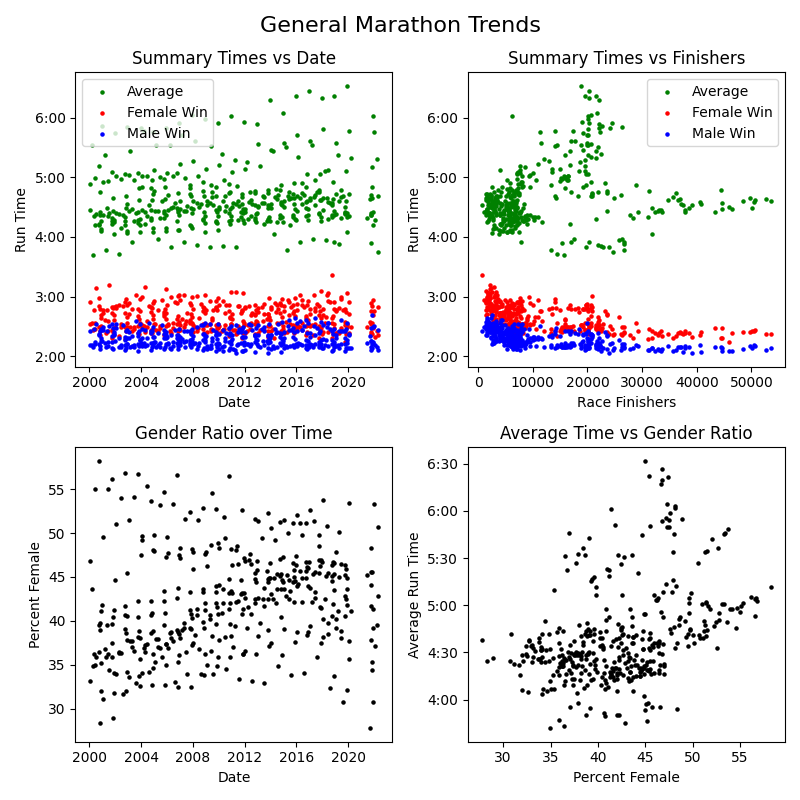

In [33]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(X['Date'],y_average,color='g', s=5, label='Average')
ax1.scatter(X['Date'],y_female,color='r', s=5, label='Female Win')
ax1.scatter(X['Date'],y_male,color='b', s=5, label='Male Win')
# ax1.scatter(X['Date'],y_std,color='c', s=5, label='St. Dev.')
ax1.set_xlabel('Date')
ax1.set_ylabel('Run Time')
ax1.set_title('Summary Times vs Date')

ax2.scatter(X['Finishers'],y_average,color='g', s=5, label='Average')
ax2.scatter(X['Finishers'],y_female,color='r', s=5, label='Female Win')
ax2.scatter(X['Finishers'],y_male,color='b', s=5, label='Male Win')
# ax2.scatter(X['Finishers'],y_std,color='c', s=5, label='St. Dev.')
ax2.set_xlabel('Race Finishers')
ax2.set_ylabel('Run Time')
ax2.set_title('Summary Times vs Finishers')

ax3.scatter(X['Date'],X['Percent Female'],color='k', s=5, label='_none')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percent Female')
ax3.set_title('Gender Ratio over Time')

ax4.scatter(X['Percent Female'],y_average,color='k', s=5, label='Average')
# ax4.scatter(X['Percent Female'],y_std,color='c', s=5, label='St. Dev.')
ax4.set_xlabel('Percent Female')
ax4.set_ylabel('Average Run Time')
ax4.set_title('Average Time vs Gender Ratio')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()
ax4.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax4.yaxis.set_major_formatter(formatter)

fig.suptitle('General Marathon Trends', fontsize=16)
# axs[0,0].xaxis.set_tick_params(rotation=45)
fig.tight_layout()

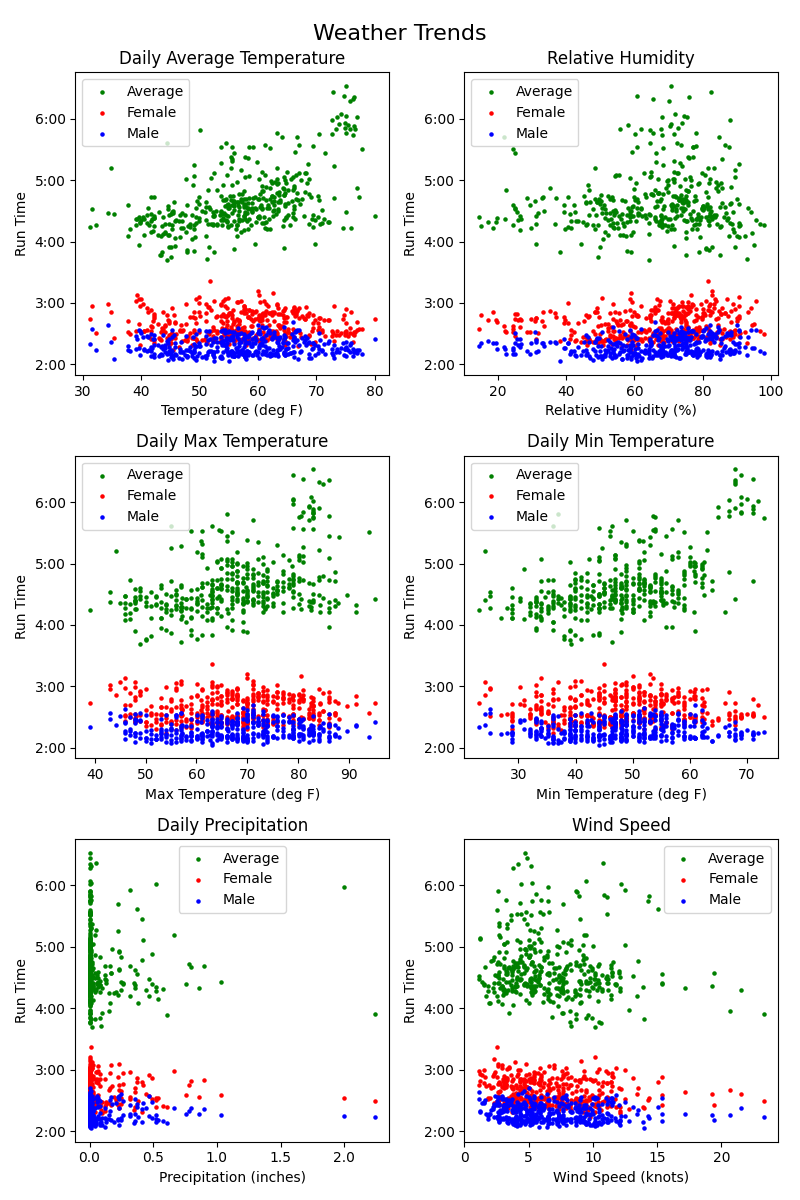

In [34]:
# Plot weather data
# 'TEMP', 'RELHUM',
# 'MAX', 'MIN',
# 'PRCP', 'WDSP'
fig, axs = plt.subplots(3,2,figsize=(8,12))
((ax1,ax2),(ax3,ax4),(ax5,ax6)) = axs

ax1.scatter(X['TEMP'],y_average,color='g', s=5, label='Average')
ax1.scatter(X['TEMP'],y_female,color='r', s=5, label='Female')
ax1.scatter(X['TEMP'],y_male,color='b', s=5, label='Male')
# ax1.scatter(X['TEMP'],y_std,color='c', s=5, label='St. Dev.')
ax1.set_xlabel('Temperature (deg F)')
ax1.set_ylabel('Run Time')
ax1.set_title('Daily Average Temperature')

ax2.scatter(X['RELHUM'],y_average,color='g', s=5, label='Average')
ax2.scatter(X['RELHUM'],y_female,color='r', s=5, label='Female')
ax2.scatter(X['RELHUM'],y_male,color='b', s=5, label='Male')
# ax2.scatter(X['RELHUM'],y_std,color='c', s=5, label='St. Dev.')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('Run Time')
ax2.set_title('Relative Humidity')

ax3.scatter(X['MAX'],y_average,color='g', s=5, label='Average')
ax3.scatter(X['MAX'],y_female,color='r', s=5, label='Female')
ax3.scatter(X['MAX'],y_male,color='b', s=5, label='Male')
# ax3.scatter(X['MAX'],y_std,color='c', s=5, label='St. Dev.')
ax3.set_xlabel('Max Temperature (deg F)')
ax3.set_ylabel('Run Time')
ax3.set_title('Daily Max Temperature')

ax4.scatter(X['MIN'],y_average,color='g', s=5, label='Average')
ax4.scatter(X['MIN'],y_female,color='r', s=5, label='Female')
ax4.scatter(X['MIN'],y_male,color='b', s=5, label='Male')
# ax4.scatter(X['MIN'],y_std,color='c', s=5, label='St. Dev.')
ax4.set_xlabel('Min Temperature (deg F)')
ax4.set_ylabel('Run Time')
ax4.set_title('Daily Min Temperature')

ax5.scatter(X['PRCP'],y_average,color='g', s=5, label='Average')
ax5.scatter(X['PRCP'],y_female,color='r', s=5, label='Female')
ax5.scatter(X['PRCP'],y_male,color='b', s=5, label='Male')
# ax5.scatter(X['PRCP'],y_std,color='c', s=5, label='St. Dev.')
ax5.set_xlabel('Precipitation (inches)')
ax5.set_ylabel('Run Time')
ax5.set_title('Daily Precipitation')

ax6.scatter(X['WDSP'],y_average,color='g', s=5, label='Average')
ax6.scatter(X['WDSP'],y_female,color='r', s=5, label='Female')
ax6.scatter(X['WDSP'],y_male,color='b', s=5, label='Male')
# ax6.scatter(X['WDSP'],y_std,color='c', s=5, label='St. Dev.')
ax6.set_xlabel('Wind Speed (knots)')
ax6.set_ylabel('Run Time')
ax6.set_title('Wind Speed')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Weather Trends', fontsize=16)

fig.tight_layout()

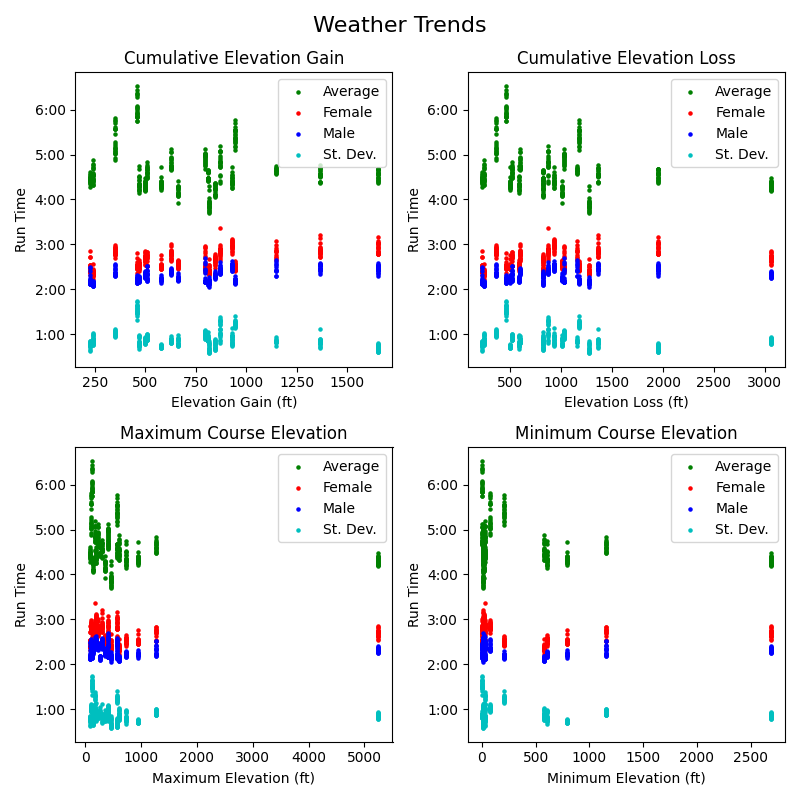

In [35]:
# Plot elevation data
# 'Elev Gain', 'Elev Loss',
# 'Elev Max', 'Elev Min', 
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(X['Elev Gain'],y_average,color='g', s=5, label='Average')
ax1.scatter(X['Elev Gain'],y_female,color='r', s=5, label='Female')
ax1.scatter(X['Elev Gain'],y_male,color='b', s=5, label='Male')
ax1.scatter(X['Elev Gain'],y_std,color='c', s=5, label='St. Dev.')
ax1.set_xlabel('Elevation Gain (ft)')
ax1.set_ylabel('Run Time')
ax1.set_title('Cumulative Elevation Gain')

ax2.scatter(X['Elev Loss'],y_average,color='g', s=5, label='Average')
ax2.scatter(X['Elev Loss'],y_female,color='r', s=5, label='Female')
ax2.scatter(X['Elev Loss'],y_male,color='b', s=5, label='Male')
ax2.scatter(X['Elev Loss'],y_std,color='c', s=5, label='St. Dev.')
ax2.set_xlabel('Elevation Loss (ft)')
ax2.set_ylabel('Run Time')
ax2.set_title('Cumulative Elevation Loss')

ax3.scatter(X['Elev Max'],y_average,color='g', s=5, label='Average')
ax3.scatter(X['Elev Max'],y_female,color='r', s=5, label='Female')
ax3.scatter(X['Elev Max'],y_male,color='b', s=5, label='Male')
ax3.scatter(X['Elev Max'],y_std,color='c', s=5, label='St. Dev.')
ax3.set_xlabel('Maximum Elevation (ft)')
ax3.set_ylabel('Run Time')
ax3.set_title('Maximum Course Elevation')

ax4.scatter(X['Elev Min'],y_average,color='g', s=5, label='Average')
ax4.scatter(X['Elev Min'],y_female,color='r', s=5, label='Female')
ax4.scatter(X['Elev Min'],y_male,color='b', s=5, label='Male')
ax4.scatter(X['Elev Min'],y_std,color='c', s=5, label='St. Dev.')
ax4.set_xlabel('Minimum Elevation (ft)')
ax4.set_ylabel('Run Time')
ax4.set_title('Minimum Course Elevation')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Weather Trends', fontsize=16)

fig.tight_layout()

### Define feature and target variables ###

In [429]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

In [242]:
# Train-test split is random
from sklearn.model_selection import train_test_split

# Feature Variables
X = full_df[[#'Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

X_ave_train, X_ave_test, y_ave_train, y_ave_test = train_test_split(X, y_average, random_state=0)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X, y_female, random_state=0)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X, y_male, random_state=0)

# X.dtypes
# y_average.dtypes

In [159]:
print(f'Total events: {len(X)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/len(X)}')

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


In [278]:
# Train-test split is by Date
train_df = full_df[full_df['Date'] < pd.to_datetime('2016-01-01')].sort_values('Date')
test_df = full_df[full_df['Date'] >= pd.to_datetime('2016-01-01')].sort_values('Date')

# Dates will be in days (float) since Jan 1, 2000
train_df['Date'] = (pd.to_datetime(train_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')
test_df['Date'] = (pd.to_datetime(test_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Feature Variables
features = [#'Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']

X_ave_train = train_df[features]
X_f_train = X_ave_train
X_m_train = X_ave_train

X_ave_test = test_df[features]
X_f_test = X_ave_test
X_m_test = X_ave_test

# Target Variables: Run times will be in seconds (float)
y_ave_train = train_df['Average Time'] / np.timedelta64(1, 's')
y_m_train = train_df['Male Win'] / np.timedelta64(1, 's')
y_f_train = train_df['Female Win'] / np.timedelta64(1, 's')

y_ave_test = test_df['Average Time'] / np.timedelta64(1, 's')
y_m_test = test_df['Male Win'] / np.timedelta64(1, 's')
y_f_test = test_df['Female Win'] / np.timedelta64(1, 's')

In [293]:
print(f'Total events: {len(X_ave_test)+len(X_ave_train)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/(len(X_ave_test)+len(X_ave_train))}')

# full_df
# test_df
# y_ave_train

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


### Linear, Ridge, and Lasso Regression: Default Parameters ###

In [440]:
# Scale the input features based on medians and inter-quartile ranges
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_ave_train_scaled = scaler.fit_transform(X_ave_train)
# we must apply the scaling to the test set that we computed for the training set
X_ave_test_scaled = scaler.transform(X_ave_test)

In [485]:
# Linear Regression with default parameters
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Create df to store scores and model coefficients
linreg_df = pd.DataFrame(columns=['R2 train','R2 test','Intercept']+list(X_ave_train.columns))

# Linear Regression
linreg_ave = LinearRegression().fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Linear Ave','R2 train'] = linreg_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Linear Ave','R2 test'] = linreg_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Linear Ave','Intercept'] = linreg_ave.intercept_
linreg_df.loc['Linear Ave'].iloc[3:] = linreg_ave.coef_

# Ridge Regression
ridge_ave = Ridge(random_state=0).fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Ridge Ave','R2 train'] = ridge_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Ridge Ave','R2 test'] = ridge_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Ridge Ave','Intercept'] = ridge_ave.intercept_
linreg_df.loc['Ridge Ave'].iloc[3:] = ridge_ave.coef_

# Lasso Regression
lasso_ave = Lasso(random_state=0, max_iter=5000).fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Lasso Ave','R2 train'] = lasso_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Lasso Ave','R2 test'] = lasso_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Lasso Ave','Intercept'] = lasso_ave.intercept_
linreg_df.loc['Lasso Ave'].iloc[3:] = lasso_ave.coef_

# print(ridge_ave.get_params().keys())
linreg_df

,R2 train,R2 test,Intercept,Date,Finishers,Males,Females,Percent Female,Elev Gain,Elev Loss,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,0.788514,0.68126,19593.253152,-126.586636,-124093.726977,67732.511341,54495.06005,601.552559,1244.574233,-2569.208459,...,-851.449312,-1231.642864,234.687394,1100.958287,-224.821498,-378.785064,2.588016,-60.489337,-210.666632,75.793795
Ridge Ave,0.783761,0.673389,16698.472905,-108.331476,211.857815,509.704031,-122.628468,575.982115,802.800267,-1561.269795,...,-804.427923,-1137.588087,172.251372,624.685607,-128.327935,-127.476089,2.674854,215.673022,-234.722059,-146.338181
Lasso Ave,0.786555,0.67852,16798.552829,-113.938817,0.0,611.50874,-0.0,583.937119,1107.697176,-2243.281117,...,-823.608795,-1191.066723,216.438124,799.074674,-124.970055,-180.334606,2.631554,1.940889,-219.406613,0.0


### Ridge and Lasso Regression with Grid Search Cross-validation ###

In [479]:
# Ridge Regression: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

ridge_shuffle_ave = Ridge(random_state=0)
grid_ridge_shuffle_ave = GridSearchCV(ridge_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_shuffle_ave.fit(X_ave_train_scaled, y_ave_train)

print(f'Best Paramters (squared error): {grid_ridge_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_ridge_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_ridge_shuffle_ave.score(X_ave_test_scaled, y_ave_test)}')

Best Paramters (squared error): {'alpha': 0.1}
Best Score (R^2): 0.7482213968174901
Test Set Score (R^2): 0.6796512931944665


In [491]:
# Lasso Regression: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

lasso_shuffle_ave = Lasso(random_state=0, max_iter=5000)
grid_lasso_shuffle_ave = GridSearchCV(lasso_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_lasso_shuffle_ave.fit(X_ave_train_scaled, y_ave_train)

print(f'Best Paramters (squared error): {grid_lasso_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_lasso_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_lasso_shuffle_ave.score(X_ave_test_scaled, y_ave_test)}')

Best Paramters (squared error): {'alpha': 1}
Best Score (R^2): 0.7495209751985819
Test Set Score (R^2): 0.6785196617111717


/Users/michael/Documents/python coding/environments/datasci4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.604e+07, tolerance: 7.643e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/python coding/environments/datasci4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.922e+07, tolerance: 6.735e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/python coding/environments/datasci4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to 

### Random Forest and Gradient Boosted Decision Tree: Default Parameters ###

In [280]:
# Random Forest Regressors: Default parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

print('Random Forest Regressors')

# Average Times
print('\n   Average Run Times')
rf_ave = RandomForestRegressor(max_depth=None, random_state=0)
rf_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {rf_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {rf_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
rf_female = RandomForestRegressor(max_depth=None, random_state=0)
rf_female.fit(X_f_train, y_f_train)
print(f'Train Score: {rf_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {rf_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
rf_male = RandomForestRegressor(max_depth=None, random_state=0)
rf_male.fit(X_m_train, y_m_train)
print(f'Train Score: {rf_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {rf_male.score(X_m_test, y_m_test)}')

# print(regr.predict([[0, 0, 0, 0]]))

Random Forest Regressors

   Average Run Times
Train Score: 0.9950461265261321
Test Score: 0.8829037493416145

   Female Win Times
Train Score: 0.9748012400958829
Test Score: 0.7060348888283718

   Male Win Times
Train Score: 0.9764619108264133
Test Score: 0.780094416964991


In [ ]:
# Random Forest Regressors

#    Average Run Times
# Train Score: 0.9950461265261321
# Test Score: 0.8829037493416145

#    Female Win Times
# Train Score: 0.9748012400958829
# Test Score: 0.7060348888283718

#    Male Win Times
# Train Score: 0.9764619108264133
# Test Score: 0.780094416964991

In [281]:
# Gradient Boosting Tree Ensembles: Default parameters
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

print('Gradient Boosting Regressors')

# Average Times
print('\n   Average Run Times')
gb_ave = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {gb_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {gb_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
gb_female = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_female.fit(X_f_train, y_f_train)
print(f'Train Score: {gb_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {gb_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
gb_male = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_male.fit(X_m_train, y_m_train)
print(f'Train Score: {gb_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {gb_male.score(X_m_test, y_m_test)}')

# reg.predict(X_test[1:2])

Gradient Boosting Regressors

   Average Run Times
Train Score: 0.993531533363386
Test Score: 0.8689688733102867

   Female Win Times
Train Score: 0.9711857846763055
Test Score: 0.618034174759329

   Male Win Times
Train Score: 0.9650934605583189
Test Score: 0.7489883911130311


In [ ]:
# Gradient Boosting Regressors

#    Average Run Times
# Train Score: 0.993531533363386
# Test Score: 0.8689688733102867

#    Female Win Times
# Train Score: 0.9711857846763055
# Test Score: 0.618034174759329

#    Male Win Times
# Train Score: 0.9650934605583189
# Test Score: 0.7489883911130311

### Tree Ensembles with Cross-validation ###

In [282]:
# Gradient Boosting Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_shuffle_ave = GradientBoostingRegressor(random_state=0)
grid_gb_shuffle_ave = GridSearchCV(gb_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_gb_shuffle_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_gb_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_shuffle_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Best Score (R^2): 0.9579724218584735
Test Set Score (R^2): 0.8746660975538072


In [443]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
# Best Score (R^2): 0.9579724218584735
# Test Set Score (R^2): 0.8746660975538072

# Sample all years Test, With shuffle=True, random_state=0:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.936252871209456
# Test Set Score (R^2): 0.9337701946985129

In [292]:
# Random Forest Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

rf_shuffle_ave = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_shuffle_ave = GridSearchCV(rf_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_rf_shuffle_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_rf_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_rf_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_rf_shuffle_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'max_features': 0.3, 'max_samples': 1.0}
Best Score (R^2): 0.9626093498998685
Test Set Score (R^2): 0.8831137496257951


In [472]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'max_features': 0.3, 'max_samples': 1.0}
# Best Score (R^2): 0.9626093498998685
# Test Set Score (R^2): 0.8831137496257951

In [468]:
# Create df to store model performance metrics
ave_perf_df = pd.DataFrame(columns={'Train MAE':[],'Test MAE':[],
                            'Train RMSE':[],'Test RMSE':[],'Train R2':[],'Test R2':[]})

# Calculate R2 values
ave_perf_df.loc['GB Ave','Train R2'] = grid_gb_shuffle_ave.score(X_ave_train, y_ave_train)
ave_perf_df.loc['GB Ave','Test R2'] = grid_gb_shuffle_ave.score(X_ave_test, y_ave_test)
ave_perf_df.loc['RF Ave','Train R2'] = grid_rf_shuffle_ave.score(X_ave_train, y_ave_train)
ave_perf_df.loc['RF Ave','Test R2'] = grid_rf_shuffle_ave.score(X_ave_test, y_ave_test)

# Calculate RMSE values in minutes
# tss_ave_train = ((y_ave_train - y_ave_train.mean())**2).sum()
# rmse_gb_train = ((1-gb_train_r2)*(tss_ave_train/len(y_ave_train)))**0.5/60
# rmse_rf_train = ((1-rf_train_r2)*(tss_ave_train/len(y_ave_train)))**0.5/60

# tss_ave_test = ((y_ave_test - y_ave_test.mean())**2).sum()
# rmse_gb_test = ((1-gb_test_r2)*(tss_ave_test/len(y_ave_test)))**0.5/60
# rmse_rf_test = ((1-rf_test_r2)*(tss_ave_test/len(y_ave_test)))**0.5/60

# Calculate residuals, MAE, and RMSE
gb_train_resid = (y_ave_train - grid_gb_shuffle_ave.predict(X_ave_train))/60
gb_test_resid = (y_ave_test - grid_gb_shuffle_ave.predict(X_ave_test))/60
rf_train_resid = (y_ave_train - grid_rf_shuffle_ave.predict(X_ave_train))/60
rf_test_resid = (y_ave_test - grid_rf_shuffle_ave.predict(X_ave_test))/60

ave_perf_df.loc['GB Ave','Train MAE'] = (np.absolute(gb_train_resid)).mean()
ave_perf_df.loc['GB Ave','Test MAE'] = (np.absolute(gb_test_resid)).mean()
ave_perf_df.loc['RF Ave','Train MAE'] = (np.absolute(rf_train_resid)).mean()
ave_perf_df.loc['RF Ave','Test MAE'] = (np.absolute(rf_test_resid)).mean()

ave_perf_df.loc['GB Ave','Train RMSE'] = ((gb_train_resid**2).mean())**0.5
ave_perf_df.loc['GB Ave','Test RMSE'] = ((gb_test_resid**2).mean())**0.5
ave_perf_df.loc['RF Ave','Train RMSE'] = ((rf_train_resid**2).mean())**0.5
ave_perf_df.loc['RF Ave','Test RMSE'] = ((rf_test_resid**2).mean())**0.5

# Set 'Model' and 'Train/Test' cols
# ave_perf_df['Model'] = ave_perf_df.index
# ave_perf_df['Train/Test'] = ave_perf_df.apply(lambda x: (x.Model).split()[1], axis=1)
# ave_perf_df['Model'] = ave_perf_df.apply(lambda x: (x.Model).split()[0], axis=1)

# print(f'\nGradient Boosting Model:')
# print(f'  Train MAE = {gb_train_mae:.1f} minutes')
# print(f'  Train RMSE = {gb_train_rmse:.1f} minutes')
# print(f'  Test MAE = {gb_test_mae:.1f} minutes')
# print(f'  Test RMSE = {gb_test_rmse:.1f} minutes')
# print(f'\nRandom Forest Model:')
# print(f'  Train MAE = {rf_train_mae:.1f} minutes')
# print(f'  Train RMSE = {rf_train_rmse:.1f} minutes')
# print(f'  Test MAE = {rf_test_mae:.1f} minutes')
# print(f'  Test RMSE = {rf_test_rmse:.1f} minutes')

# print(f'\nTrain MAE:')
# print(f'  Gradient Boosting: {gb_train_mae:.1f} minutes')
# print(f'  Random Forest: {rf_train_mae:.1f} minutes')

# print(f'\nTest MAE:')
# print(f'  Gradient Boosting: {gb_test_mae:.1f} minutes')
# print(f'  Random Forest: {rf_test_mae:.1f} minutes')

# print(f'\nTrain RMSE:')
# print(f'  Gradient Boosting: {gb_train_rmse:.1f} minutes')
# print(f'  Random Forest: {rf_train_rmse:.1f} minutes')

# print(f'\nTest RMSE:')
# print(f'  Gradient Boosting: {gb_test_rmse:.1f} minutes')
# print(f'  Random Forest: {rf_test_rmse:.1f} minutes')

ave_perf_df

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
GB Ave,0.71499,8.213641,0.919829,11.859849,0.998998,0.874666
RF Ave,1.503005,8.427701,2.046782,11.453193,0.995038,0.883114


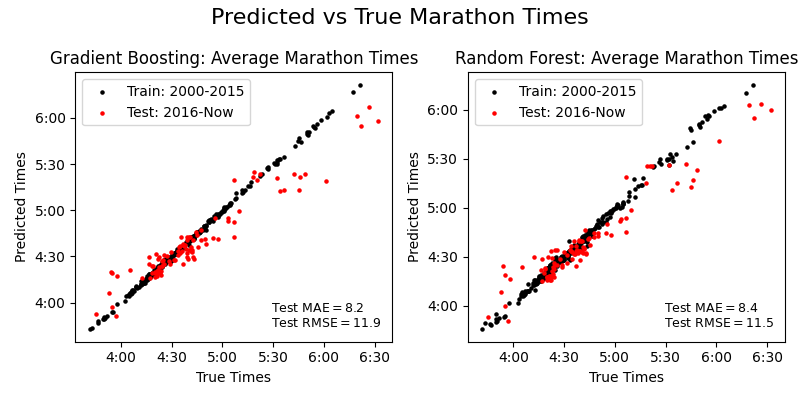

In [470]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
(ax1,ax2) = axs

y_ave_test_gb = grid_gb_shuffle_ave.predict(X_ave_test)
y_ave_train_gb = grid_gb_shuffle_ave.predict(X_ave_train)

ax1.scatter(y_ave_train,y_ave_train_gb,color='k', s=5, label='Train: 2000-2015')
ax1.scatter(y_ave_test,y_ave_test_gb,color='r', s=5, label='Test: 2016-Now')
ax1.set_xlabel('True Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Gradient Boosting: Average Marathon Times')

grid_rf_shuffle_ave
y_ave_test_rf = grid_rf_shuffle_ave.predict(X_ave_test)
y_ave_train_rf = grid_rf_shuffle_ave.predict(X_ave_train)

ax2.scatter(y_ave_train,y_ave_train_rf,color='k', s=5, label='Train: 2000-2015')
ax2.scatter(y_ave_test,y_ave_test_rf,color='r', s=5, label='Test: 2016-Now')
ax2.set_xlabel('True Times')
ax2.set_ylabel('Predicted Times')
ax2.set_title('Random Forest: Average Marathon Times')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()

# Create annotations for fit metrics
gb_note = AnchoredText(f"Test MAE$={ave_perf_df.loc['GB Ave','Test MAE']:.1f}$\nTest RMSE$={ave_perf_df.loc['GB Ave','Test RMSE']:.1f}$",
                     prop=dict(size=9), frameon=False, loc='lower right')
rf_note = AnchoredText(f"Test MAE$={ave_perf_df.loc['RF Ave','Test MAE']:.1f}$\nTest RMSE$={ave_perf_df.loc['RF Ave','Test RMSE']:.1f}$",
                     prop=dict(size=9), frameon=False, loc='lower right')
ax1.add_artist(gb_note)
ax2.add_artist(rf_note)

fig.suptitle('Predicted vs True Marathon Times', fontsize=16)

fig.tight_layout()

In [329]:
# Honolulu has all of the slowest averages because the course stays open for walking participants.
# Test data (recent years) has 4 of the 5 slowest overall average finish times.
# full_df.sort_values('Average Time', ascending=False).iloc[:20,:12]

### Tree Ensembles with Time-Series Cross-validation ###

In [203]:
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5)
all_splits = list(ts_cv.split(X_ave_train, y_ave_train))
train_0, test_0 = all_splits[0]
train_4, test_4 = all_splits[-1]
# X_ave_train.iloc[test_0]
print(len(train_0))
print(len(test_0))
print(len(train_4))
print(len(test_4))

54
50
254
50


In [240]:
# Gradient Boosting Tree Ensembles: Grid Search with Time Series cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, max_train_size=50)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_cv_ave = GradientBoostingRegressor(random_state=0)
grid_gb_ave = GridSearchCV(gb_cv_ave, param_grid = grid_values, cv=ts_cv)
grid_gb_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_gb_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
Best Score (R^2): 0.9049604776085655
Test Set Score (R^2): 0.8725139194984939


In [ ]:
# max_train_size=None:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9135540160845889
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=100:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.909646140631061
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=50:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9049604776085655
# Test Set Score (R^2): 0.8725139194984939

In [228]:
print(grid_gb_ave.cv_results_.keys())
print(len(grid_gb_ave.cv_results_['param_learning_rate']))
pd.DataFrame(grid_gb_ave.cv_results_).iloc[-5:]

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
100


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,0.043907,0.000703,0.001248,0.000025,0.2,4,50,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.954784,0.955998,0.943671,0.946558,0.917381,0.943679,0.013964,44
96,0.089692,0.003253,0.001448,0.000071,0.2,4,100,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.956030,0.957237,0.943885,0.947507,0.917175,0.944367,0.014499,38
97,0.132134,0.002028,0.001523,0.000080,0.2,4,150,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.955709,0.957273,0.943751,0.947427,0.917165,0.944265,0.014456,39
98,0.176710,0.001739,0.001615,0.000018,0.2,4,200,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.955622,0.957204,0.943716,0.947393,0.917179,0.944223,0.014423,41
99,0.218167,0.001185,0.001662,0.000072,0.2,4,250,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.955574,0.957183,0.943690,0.947422,0.917221,0.944218,0.014398,42


### To Implement: ###
__Gradient Boosting and Random Forest__
1. Test larger n_estimators
4. Try to unpack grid_gb_ave.cv_results_ in pandas to plot parameter trends
7. Fit and plot the female and male data sets with grid search

__Linear Regression__
1. Test linear, ridge, and lasso regression
2. Do gridsearch CV
3. Make plots for average, female, and male

__General Trends__
1. Train model using all data and plot trends of varying one feature while setting others to median value
2. Create df of R2, RMSE, and MAE values

### Pull Marathon Results from Wikipedia and Combine Date and Weather Data ###

1. Scrape race times
2. Join race dates
3. Pull weather
4. Output dictionary of dfs: one df per city, one row per race instance

['Year', 'Marathon', 'Date', 'City', 'State', 
'Winner M', 'Country M', 'Win Time M', 'Winner F', 'Country F', 'Win Time F',
'STATION', 'DATE','LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'MAX', 'MIN',
'PRCP', 'DEWP', 'WDSP', 'SLP', 'STP', 'VISIB', 'RELHUM']

In [ ]:
# Scrape Boston winner times from wikipedia
boston_url = 'https://en.wikipedia.org/wiki/List_of_winners_of_the_Boston_Marathon'
boston_women = (pd.read_html(boston_url)[2]
               [['Year','Winner','Country','Time']]
               .rename(columns = {'Time':'Win Time F','Winner':'Winner F','Country':'Country F'})
               )
boston_men = (pd.read_html(boston_url)[1]
               [['Year','Winner','Country','Time']]
               .rename(columns = {'Time':'Win Time M','Winner':'Winner M','Country':'Country M'})
              )
boston = boston_men.merge(boston_women, how='outer', left_on='Year', right_on='Year')
boston[['Marathon','City','State']] = ['Boston','Boston', 'MA']

# Scrape Chicago winner times from wikipedia
chicago_url = 'https://en.wikipedia.org/wiki/List_of_winners_of_the_Chicago_Marathon'
chicago = (pd.read_html(chicago_url)[0].iloc[:,:-1]
          .rename(columns={'Male athlete':'Winner M', 'Country':'Country M', 'Time':'Win Time M',
                          'Female athlete':'Winner F', 'Country.1':'Country F', 'Time.1':'Win Time F'})
          )
chicago[['Marathon','City','State']] = ['Chicago','Chicago', 'IL']
for col in ['Win Time M','Win Time F']:
    chicago[col] = chicago.apply(lambda x: x[col].strip(' WR'), axis=1)

# Scrape New York winner times from wikipedia
nyc_url = 'https://en.wikipedia.org/wiki/List_of_winners_of_the_New_York_City_Marathon'
nyc_women = (pd.read_html(nyc_url)[3]
               [['Year','Winner','Country','Time']]
               .rename(columns = {'Time':'Win Time F','Winner':'Winner F','Country':'Country F'})
              )
nyc_men = (pd.read_html(nyc_url)[1]
               [['Year','Winner','Country','Time']]
               .rename(columns = {'Time':'Win Time M','Winner':'Winner M','Country':'Country M'})
              )
nyc = nyc_men.merge(nyc_women, how='outer', left_on='Year', right_on='Year')
nyc = nyc[nyc['Year'] != 2020] # remove 2020 virtual race event
nyc[['Marathon','City','State']] = ['New York City','New York City', 'NY']

# Put these preliminary dfs into a dict for iterative cleaning
dfs = {'Boston':boston, 'Chicago':chicago, 'New York City':nyc}
clean_dfs = {}

for city, df in dfs.items():
    # Convert finish times
    for finish_time in ['Win Time F','Win Time M']:
        df[finish_time] = df[finish_time].apply(convert_time)
    
    # Join race dates df
    dates_df = pd.read_csv('date_csvs/combined_race_dates.csv')
    df = df.merge(dates_df, how='inner', left_on=['Year','Marathon'], right_on=['Year','Marathon'])
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get the weather data
    df[weather_cols] = df.apply(lambda x: get_weather(x.Date, x.City), axis=1, result_type='expand')
    df['RELHUM'] = df.apply(lambda x: calc_humidity(x.TEMP, x.DEWP), axis=1)
    
    # Reorder columns and remove rows without weather data or race results
    df = (df[['Year', 'Marathon', 'Date', 'City', 'State', 
             'Winner M', 'Country M', 'Win Time M', 'Winner F', 'Country F', 'Win Time F', 
             'STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'MAX','MIN', 
             'PRCP', 'DEWP', 'WDSP', 'SLP', 'STP', 'VISIB', 'RELHUM']]
          .dropna(subset=weather_cols)
          .dropna(subset=['Win Time M']))
    
    clean_dfs[city] = df

full_df = pd.concat(clean_dfs)

In [ ]:
# Check DB outputs

full_df.describe()
# full_df[full_df['Marathon']=='New York City'].iloc[-20:]

In [ ]:
# Save the race results to a csv
directory = 'results_with_weather_csvs/'
if not os.path.exists(directory):
    print(f'Directory created: {directory}')
    os.mkdir(directory)

now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
full_df.to_csv(f'{directory}full_df_{now}.csv',index=False)

### Old Visualizations ###

In [ ]:
# Visualize some data

boston = clean_dfs['Boston'].loc[:,['Win Time M','Win Time F','Date','TEMP','PRCP','WDSP','RELHUM']].iloc[-40:]
chicago = clean_dfs['Chicago'].loc[:,['Win Time M','Win Time F','Date','TEMP','PRCP','WDSP','RELHUM']].iloc[-40:]
nyc = clean_dfs['New York City'].loc[:,['Win Time M','Win Time F','Date','TEMP','PRCP','WDSP','RELHUM']].iloc[-40:]
# print(type(test_df.iloc[-1,0]))
# print(test_df.head())
# test_df.plot()

fig, ax = plt.subplots()
ax.scatter(boston['Win Time M'],boston['Win Time F'],color='b')
ax.scatter(chicago['Win Time M'],chicago['Win Time F'],color='r')
ax.scatter(nyc['Win Time M'],chicago['Win Time F'],color='g')

# Set tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
fig.size =[4.4, 4.8]

ax1.scatter(boston['TEMP'],boston['Win Time F'],color='b')
ax1.scatter(chicago['TEMP'],chicago['Win Time F'],color='r')
ax1.scatter(nyc['TEMP'],nyc['Win Time F'],color='g')

ax2.scatter(boston['RELHUM'],boston['Win Time M'],color='b')
ax2.scatter(chicago['RELHUM'],chicago['Win Time M'],color='r')
ax2.scatter(nyc['RELHUM'],nyc['Win Time M'],color='g')

# Set tick labels
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()

## Outline

### Pull Race Dates ###

1. scrape race dates -> __add 'Marathon' column__
2. __combine race dates into one df__
3. save race dates; one csv total

['Year', __'Marathon'__, 'Date']

### New Way: Pull Data ###

#### Save Race Results Separately ####

1. Scrape race results
2. Join race dates on ['Year', __'Marathon'__]
3. __Save race results; one csv per city__
4. Output dictionary of dfs: one df per city, one row per race date

['Year', 'Marathon', 'Date', 'City', 'State', <br>
'Winner M', 'Country M', 'Win Time M', 'Winner F', 'Country F', 'Win Time F']

#### Save Weather Data Separately ####

5. __Load Race Results__
6. Pull weather using ['Date', 'City']
7. __Save weather data; one csv per city__
8. Output dictionary of dfs: one df per city, one row per race date

['Date', 'City', 'STATION', 'DATE','LATITUDE', 'LONGITUDE', 'ELEVATION', <br>
'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'SLP', 'STP', 'VISIB', 'RELHUM']

### Save DF to Local Drive ###

1. -> Merge all cities into one df
2. -> Save final df to csv or sqlite

### Data Frames ###

### Race Results Original ###
['Year', 'Marathon', __'Date', 'City'__, 'State', <br>
'Winner M', 'Country M', 'Win Time M', 'Winner F', 'Country F', 'Win Time F']

### Race Results New ###
['Year', 'Marathon', __'Date', 'City'__, 'State', <br>
'0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']<br>
__Maybe?__:['Winner M', 'Country M', 'Win Time M', 'Winner F', 'Country F', 'Win Time F']

### Weather ###
[__'Date', 'City'__, 'STATION', 'DATE','LATITUDE', 'LONGITUDE', 'ELEVATION', <br>
'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'SLP', 'STP', 'VISIB', 'RELHUM']

pd.melt(race_results, id_vars=['Year', 'Marathon', 'Date', 'City', 'State'],<br>
        value_vars=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', ...])<br>
df = race_results.merge(weather, how='inner', left_on=['Date', 'City'], right_on=['Date', 'City'])

## Testing Stuff

### Various test code

In [ ]:
driver.close()

In [151]:
# Find Decile Places
finishers = 5137.0
deciles = [str(int(decile)) for decile in np.linspace(1,finishers,11)]
# event_df.loc[event_id,['D1 Place','D2 Place','D3 Place]] = 
print(deciles)

finisher = 799
print(finisher)
option = int((finisher+99)/100)
print(option)
print(options_text[option])


['1', '514', '1028', '1541', '2055', '2569', '3082', '3596', '4109', '4623', '5137']
799
8
701 - 800


In [ ]:
# get_race_date(2021, 'Chicago')

dates_dfs['Boston']

In [ ]:
# Scrape Chicago winner times from wikipedia
chicago_url = 'https://en.wikipedia.org/wiki/List_of_winners_of_the_Chicago_Marathon'
chicago = (pd.read_html(chicago_url)[0].iloc[:,:-1]
          .rename(columns={'Male athlete':'Winner M', 'Country':'Country M', 'Time':'Time M',
                          'Female athlete':'Winner F', 'Country.1':'Country F', 'Time.1':'Time F'})
          )
chicago[['Marathon','City','State']] = ['Chicago','Chicago', 'IL']
for col in ['Time M','Time F']:
    chicago[col] = chicago.apply(lambda x: x[col].strip(' WR'), axis=1)

chicago.head(10)

In [ ]:
# Parse tables from urls

boston_url = 'https://en.wikipedia.org/wiki/List_of_winners_of_the_Boston_Marathon'
# 'https://www.baa.org/races/boston-marathon/results/champions'

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

dfs = pd.read_html(page.text)
dfs[2][::-1]

In [ ]:
Boston = clean_dfs[0]

def calc_humidity(temp_f,dewpoint_f):
    T = (temp_f-32)*5/9
    DP = (dewpoint_f-32)*5/9
    a = 17.625
    b = 243.04
    RH = 100*(math.exp((a*DP)/(b+DP))/math.exp((a*T)/(b+T)))
    # https://bmcnoldy.rsmas.miami.edu/Humidity.html
    return RH

# calc_humidity(60,40)    

In [ ]:
# import urllib.request, urllib.parse, urllib.error
# import ssl

# NCEI Global Summary of the Day:
# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516

# Data types: https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
# TEMP - Mean temperature (.1 Fahrenheit)
# DEWP - Mean dew point (.1 Fahrenheit)
# SLP - Mean sea level pressure (.1 mb)
# STP - Mean station pressure (.1 mb)
# VISIB - Mean visibility (.1 miles)
# WDSP – Mean wind speed (.1 knots)
# MXSPD - Maximum sustained wind speed (.1 knots)
# GUST - Maximum wind gust (.1 knots)
# MAX - Maximum temperature (.1 Fahrenheit)
# MIN - Minimum temperature (.1 Fahrenheit)
# PRCP - Precipitation amount (.01 inches)
# SNDP - Snow depth (.1 inches)
# FRSHTT – Indicator for occurrence of:
#                               Fog
#                               Rain or Drizzle
#                               Snow or Ice Pellets
#                               Hail
#                               Thunder
#                               Tornado/Funnel Cloud

# Find Stations: https://www.ncei.noaa.gov/maps/daily/?layers=0001
# Boston KBOS Airport 72509014739: 1943-11-21, 2020-04-08
# Chicago ORD Airport 72530094846: 1946-10-09, 2020-04-08
# ---Chicago MDW Airport 72534014819: 1973-01-01, 2020-04-08
# New York City Central Park 72505394728: 1943-12-01, 2020-04-08
# ---New York City LGA Airport 72503014732: 1973-01-01, 2020-04-08
# Berlin Tegel Airport 10382099999: 1936-06-12, 2020-04-07
# London Heathrow 3772099999: 1948-12-01, 2020-04-07
# Tokyo Downtown 47662099999: 1952-12-31, 2020-04-07
# ---Tokyo Airport 47671099999: 1946-09-11, 2020-04-07

station_ids = {'Boston':'72509014739','Chicago':'72530094846','New York City':'72505394728',
               'Berlin':'10382099999','London':'3772099999','Tokyo':'47662099999'}

weather_cols = ['STATION','DATE','LATITUDE','LONGITUDE','ELEVATION',
                'TEMP','MAX','MIN','PRCP','DEWP',
                'WDSP','SLP','STP','VISIB']

# Function for getting NCEI weather data
def get_weather(date, city):
    try:
        # station_ids = {'Boston':'72509014739','Chicago':'72530094846','New York City':'72505394728',
        #                'Berlin':'10382099999','London':'3772099999','Tokyo':'47662099999'}
        station_id = station_ids[city]
        year = date.year
        file_name = f'weather_csvs/{station_id}_{year}.csv'
        
        try:
            temp_df = pd.read_csv(file_name)
        
        except:
            # Ignore SSL certificates errors.
            # ctx = ssl.create_default_context()
            # ctx.check_hostname = False
            # ctx.verify_mode = ssl.CERT_NONE

            url = f'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{station_id}.csv'
            # url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2005/72509014739.csv'
            # print(f'URL: {url}')

            temp_df = pd.read_csv(url)
            temp_df.to_csv(file_name,index=False)
            print(f'Retrieved {file_name} online and saved to local drive.')
        
        temp_df['DATE'] = pd.to_datetime(temp_df['DATE'], format="%Y-%m-%d")
        weather_data = temp_df[temp_df['DATE']==date]
        weather_data = weather_data[weather_cols].squeeze().tolist()
    except:
        weather_data = pd.DataFrame(columns = weather_cols,
                                    index = [0]).squeeze().tolist()
        
    return weather_data

get_weather(clean_dfs[0].iloc[-1,1],clean_dfs[0].iloc[-1,3])

# Relative humidity calculator
def calc_humidity(temp_f,dewpoint_f):
    # Convert temps from F to C
    T = (temp_f-32)*5/9
    DP = (dewpoint_f-32)*5/9
    
    # Save constants
    a = 17.625
    b = 243.04
    
    # Calculate based on https://bmcnoldy.rsmas.miami.edu/Humidity.html
    RH = 100*(math.exp((a*DP)/(b+DP))/math.exp((a*T)/(b+T)))
    return RH

In [ ]:
# Function for getting National Weather Service data
import urllib.request, urllib.parse, urllib.error
import http
import sqlite3
import json
import time
import ssl
import sys

def get_weather(date, city, state):
    
    # https://www.w3.org/TR/NOTE-datetime
    # Complete date plus hours and minutes:
    # YYYY-MM-DDThh:mmTZD (eg 1997-07-16T19:20+01:00)

    serviceurl = 'https://api.weather.gov' # /stations/{stationId}/observations/{time}
    # https://api.weather.gov/stations/PANC/observations?start=2022-05-08T11%3A53%3A00%2B00%3A00&end=2022-05-08T23%3A53%3A00%2B00%3A00&limit=5
    # https://api.weather.gov/stations/PANC/observations/2022-05-09T23%3A53%3A00%2B00%3A00
    
    # Ignore SSL certificate errors
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

#     parms = dict()
#     parms['$stationID'] = 'KBOS' # default limit is 1,000 rows, total rows is ~80,000
#     parms['$time'] = '2022-05-08T11:53:00+00:00'

#     url = serviceurl + '?' + urllib.parse.urlencode(parms) # + "?$limit=80000"
    
    stationId = 'BHBM3'
    time = '2022-05-08T11:53:00+00:00'
    url = serviceurl + f'/stations/{stationId}/observations/{time}'

    print('Retrieving', url)
    uh = urllib.request.urlopen(url, context=ctx)
    data = uh.read().decode()
    print('Retrieved', len(data), 'characters') #, data[:500].replace('\n', ' '))
    print()
    print(data[-500:])
    print()

    # return weather

get_weather(2015, 'Boston', 'MA')



In [ ]:
points = [[-71.0192309,42.388364],
          [-71.02441069999999,42.3669552],
          [-70.99544219999999,42.3631277],
          [-70.99025629999998,42.3845362],
          [-71.0192309,42.388364]]

test_df = pd.DataFrame(data = points, columns = ['lat','long'])
print(list(zip(test_df['long'],test_df['lat'])))

fig, ax = plt.subplots()
ax.plot(test_df['lat'],test_df['long'])
# plt.show()

In [ ]:
year = 2022
April_dates = pd.date_range(
                start = str(year)+'-4-1', 
                end = str(year)+'-5-1', 
                freq='D').to_series()
          
Mondays = April_dates[April_dates.dt.dayofweek == 0]
date = Mondays[2].date()
print(date)
date

In [ ]:
# Read in the data saved from wikipedia
boston_women=pd.read_html("Boston_Marathon_Winners.html")[2]
boston_men = pd.read_html("Boston_Marathon_Winners.html")[1]
# source: https://en.wikipedia.org/wiki/List_of_winners_of_the_Boston_Marathon

# Function to convert times
def convert_time(time):
    try:
        converted = pd.to_datetime(time).time()
        return converted
    except:
        return np.nan

# Convert times
boston_women['Time'] = boston_women['Time'].apply(convert_time)
boston_men['Time'] = boston_men['Time'].apply(convert_time)

# Convert years

# Remove rows without winners
boston_women = boston_women.dropna(subset=['Time'])
boston_men = boston_men.dropna(subset=['Time'])

print(type(boston_men.loc[0,'Time']))

print(boston_men.iloc[-15:])



In [ ]:
station_ids

### Figuring out which bs4 table to parse

In [232]:
# Scrape race results for all race events

# List of initial race IDs used by MarathonGuide.com
init_ids = {#'Boston':'15000417',
        # 'Chicago':'67001022',
        'New York City':'472001105'
       }

# Dictionary where we'll add a df for each event
events_dfs = {}

for event, init_id in init_ids.items():
    # Create driver and point to initial url
    event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={init_id}'
    driver = webdriver.Safari()
    driver.get(event_url)
    sleeptime = np.random.uniform(6, 9)
    time.sleep(sleeptime)
    
    # (not needed for now)
    # # Parse page with bs4
    # soup = BeautifulSoup(driver.page_source)
    # # Get a list of years from the 'a' tags
    # print([el.get_text() for el in soup.find_all('a', string=re.compile(r'\d{4}'))])
    
    # Find all the event IDs in the 'a' tag hyperlinks. Each corresponds to a year of the event.
    event_ids = sorted(list(set(re.findall(r'MIDD=(\d+)', driver.page_source))), reverse=True)[:1]
    
    # Create df for this event. First column is event ID.
    event_df = (pd.DataFrame({'Event ID':event_ids})
                .set_index('Event ID'))
    
    for event_id in event_ids:
        event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={event_id}'
        driver.get(event_url)
        sleeptime = np.random.uniform(6, 9)
        time.sleep(sleeptime)
    
        # Find the event name, date, city, state, number of finishers
        event_df.loc[event_id,'Event Name'] = re.findall(r'<b>(.+)</b> - Results', driver.page_source)[0]
        event_df.loc[event_id,'Date'] = re.findall(r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
        event_df.loc[event_id,['City','State']] = re.findall(r'([\w\- ]+), ([A-Z]{2})', driver.page_source)[0]
        event_df.loc[event_id,'Finishers'] = re.findall(r'Finishers: (\d+)', driver.page_source)[0]
        event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
            r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
        
        # Calculate Decile Places
        finishers = float(event_df.loc[event_id,'Finishers'])
        decile_places = [str(int(decile)) for decile in np.linspace(1,finishers,11)]
        event_df.loc[event_id,['D0 Place','D1 Place','D2 Place','D3 Place','D4 Place','D5 Place',
                              'D6 Place','D7 Place','D8 Place','D9 Place', 'D10 Place']
                    ] = decile_places
        
        # Names for cols for decile times we'll iterate over
        decile_cols = ['D0','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
        
        
        # options_text = [option.get_attribute("text") for option in all_options]
        # option = element.find_element(by=By.XPATH, value=f"//*[contains(text(), '1501')]") #{options_text[8]}
        
        # Find the dropdown/Select element for finisher place range/options
        for finish_place, decile in zip(decile_places[1:2],decile_cols[1:2]):
            selector = driver.find_element(by=By.XPATH, value="//select[@name='RaceRange']")
            all_options = selector.find_elements(by=By.TAG_NAME, value="option")
            results_page = int((int(finish_place)+99)/100)
            option = all_options[results_page]
            submit_button = driver.find_element(by=By.XPATH, value="//input[@name='SubmitButton']")
            
            selector.click()
            option.click()
            submit_button.click()
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)
            
            print(finish_place)
            print(type(finish_place))
            soup = BeautifulSoup(driver.page_source)
            
            table1 = soup.find_all('table')[9]
            table2 = table1.find_all('table')[3]
            table3 = table2.find_all('table')[0]
            table4 = table3.find_all('table')[0]
            table5 = table4.find_all('table')[0]
            
            results_df = pd.read_html(str(table5))[0].iloc[2:]
            results_df.columns = results_df.iloc[0]
            print(results_table.head())
            
            # print(f'len tables1: {len(tables1)}')
            # tables1 = soup.find_all('table')
            # for a, table1 in enumerate(tables1):
            #     print(f'    table1 a = {a}')
            #     #####-----#####
            #     rows = table1.find_all('tr')
            #     for row in rows:
            #         cols = row.find_all('th')
            #         cols = [ele.text.strip() for ele in cols]
            #         for col in cols:
            #             if col == 'Net Time': print(f'#####   {col}   #####')
            #             #####-----#####
            #     tables2 = table1.find_all('table')
            #     for b, table2 in enumerate(tables2):
            #         print(f'        table2 b = {b}')
            #         #####-----#####
            #         rows = table2.find_all('tr')
            #         for row in rows:
            #             cols = row.find_all('th')
            #             cols = [ele.text.strip() for ele in cols]
            #             for col in cols:
            #                 if col == 'Net Time': print(f'#####   {col}   #####')
            #                 #####-----#####
            #         tables3 = table2.find_all('table')
            #         for c, table3 in enumerate(tables3):
            #             print(f'            table3 c = {c}')
            #             #####-----#####
            #             rows = table3.find_all('tr')
            #             for row in rows:
            #                 cols = row.find_all('th')
            #                 cols = [ele.text.strip() for ele in cols]
            #                 for col in cols:
            #                     if col == 'Net Time': print(f'#####   {col}   #####')
            #                     #####-----#####
            #             tables4 = table3.find_all('table')
            #             for d, table4 in enumerate(tables4):
            #                 print(f'                table4 d = {d}')
            #                 #####-----#####
            #                 rows = table4.find_all('tr')
            #                 for row in rows:
            #                     cols = row.find_all('th')
            #                     cols = [ele.text.strip() for ele in cols]
            #                     for col in cols:
            #                         if col == 'Net Time': print(f'#####   {col}   #####')
            #                         #####-----#####
            #                 tables5 = table4.find_all('table')
            #                 for e, table5 in enumerate(tables5):
            #                     print(f'                    table5 e = {e}')
            #                     #####-----#####
            #                     rows = table5.find_all('tr')
            #                     for row in rows:
            #                         cols = row.find_all('th')
            #                         cols = [ele.text.strip() for ele in cols]
            #                         for col in cols:
            #                             if col == 'Net Time': print(f'#####   {col}   #####')
            #                             #####-----#####
            #                     tables6 = table5.find_all('table')
            #                     for f, table6 in enumerate(tables6):
            #                         print(f'                        table6 f = {f}')
            #                         #####-----#####
            #                         rows = table6.find_all('tr')
            #                         for row in rows:
            #                             cols = row.find_all('th')
            #                             cols = [ele.text.strip() for ele in cols]
            #                             for col in cols:
            #                                 if col == 'Net Time': print(f'#####   {col}   #####')
            #                                 #####-----#####
            #                         tables7 = table6.find_all('table')
            #                         for g, table7 in enumerate(tables7):
            #                             print(f'                            table7 g = {g}')
            #                             #####-----#####
            #                             rows = table7.find_all('tr')
            #                             for row in rows:
            #                                 cols = row.find_all('th')
            #                                 cols = [ele.text.strip() for ele in cols]
            #                                 for col in cols:
            #                                     if col == 'Net Time': print(f'#####   {col}   #####')
            #                                     #####-----#####
            #                             tables8 = table7.find_all('table')
            #                             for h, table8 in enumerate(tables8):
            #                                 print(f'                                table8 h = {h}')
            #                                 #####-----#####
            #                                 rows = table8.find_all('tr')
            #                                 for row in rows:
            #                                     cols = row.find_all('th')
            #                                     cols = [ele.text.strip() for ele in cols]
            #                                     for col in cols:
            #                                         if col == 'Net Time': print(f'#####   {col}   #####')
            #                                         #####-----#####
            #                                 tables9 = table8.find_all('table')
                                    
            # print(f'rows: {len(soup.find_all("tr"))}')
            # print(f'data: {len(soup.find_all("td"))}')
                # print(tr)
            # temp_df = pd.read_html(driver.page_source)[1][2]
            # print(temp_df.head())
            driver.get(event_url)
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)
    
    events_dfs[event] = event_df

#     # Find the dropdown/Select element for year range/options
#     element = driver.find_element(by=By.XPATH, value="//select[@name='starty']")
#     all_options = element.find_elements(by=By.TAG_NAME, value="option")
#     # Each table of race dates will be added to the list, then combined
#     temp_dfs = []
    
#     for option in all_options:
#         if option.get_attribute("value") < '2028':
#             # Open the drop down and select each option, give time to load
#             element.click()
#             option.click()
#             sleeptime = np.random.uniform(6, 9)
            # time.sleep(sleeptime)

#             # Read in the table of race dates
#             df = pd.read_html(driver.page_source)[1]
#             temp_dfs.append(df[['Year','Date']])
#         else: continue

    driver.close()

# Combine all events
combined_df = (pd.concat(events_dfs.values())
               .astype({'Finishers':'float', 'Date':'datetime64[D]',
                       'Male Win':'datetime64', 'Female Win':'datetime64'}))

2494
<class 'str'>
                                0             1                    2       3  \
2  Last Name, First Name(Sex/Age)  OverAllPlace  Sex Place/Div Place     DIV   
3             Steven Schiff (M38)          2401           1969 / 382  M35-39   
4             Cody Curatolo (M29)          2402           1970 / 352  M25-29   
5           Brandon Primack (M45)          2403           1971 / 221  M45-49   
6             Eric Ratzlaff (M32)          2404           1972 / 414  M30-34   

          4                        5         6    7  
2  Net Time     City, State, Country  AG Time*  BQ*  
3   3:27:39     Jersey City, NJ, USA   3:25:46  NaN  
4   3:27:41  Lake Hopatcong, NJ, USA   3:27:41  NaN  
5   3:27:41        New York, NY, USA   3:14:21  NaN  
6   3:27:42   Saint Charles, MO, USA   3:27:42  NaN  


In [311]:
# Find the table structure of soup
print(str(soup)[0:100])

# print(f'len tables1: {len(tables1)}')
tables1 = soup.find_all('table')
for a, table1 in enumerate(tables1):
    print(f'    table1 a = {a}')
    #####-----#####
    rows = table1.find_all('tr')
    for row in rows:
        cols = row.find_all('th')
        cols = [ele.text.strip() for ele in cols]
        for col in cols:
            if col == 'Net Time': print(f'#####   {col}   #####')
            #####-----#####
    tables2 = table1.find_all('table')
    for b, table2 in enumerate(tables2):
        print(f'        table2 b = {b}')
        #####-----#####
        rows = table2.find_all('tr')
        for row in rows:
            cols = row.find_all('th')
            cols = [ele.text.strip() for ele in cols]
            for col in cols:
                if col == 'Net Time': print(f'#####   {col}   #####')
                #####-----#####
        tables3 = table2.find_all('table')
        for c, table3 in enumerate(tables3):
            print(f'            table3 c = {c}')
            #####-----#####
            rows = table3.find_all('tr')
            for row in rows:
                cols = row.find_all('th')
                cols = [ele.text.strip() for ele in cols]
                for col in cols:
                    if col == 'Net Time': print(f'#####   {col}   #####')
                    #####-----#####
            tables4 = table3.find_all('table')
            for d, table4 in enumerate(tables4):
                print(f'                table4 d = {d}')
                #####-----#####
                rows = table4.find_all('tr')
                for row in rows:
                    cols = row.find_all('th')
                    cols = [ele.text.strip() for ele in cols]
                    for col in cols:
                        if col == 'Net Time': print(f'#####   {col}   #####')
                        #####-----#####
                tables5 = table4.find_all('table')
                for e, table5 in enumerate(tables5):
                    print(f'                    table5 e = {e}')
                    #####-----#####
                    rows = table5.find_all('tr')
                    for row in rows:
                        cols = row.find_all('th')
                        cols = [ele.text.strip() for ele in cols]
                        for col in cols:
                            if col == 'Net Time': print(f'#####   {col}   #####')
                            #####-----#####
                    tables6 = table5.find_all('table')
                    for f, table6 in enumerate(tables6):
                        print(f'                        table6 f = {f}')
                        #####-----#####
                        rows = table6.find_all('tr')
                        for row in rows:
                            cols = row.find_all('th')
                            cols = [ele.text.strip() for ele in cols]
                            for col in cols:
                                if col == 'Net Time': print(f'#####   {col}   #####')
                                #####-----#####
                        tables7 = table6.find_all('table')
                        for g, table7 in enumerate(tables7):
                            print(f'                            table7 g = {g}')
                            #####-----#####
                            rows = table7.find_all('tr')
                            for row in rows:
                                cols = row.find_all('th')
                                cols = [ele.text.strip() for ele in cols]
                                for col in cols:
                                    if col == 'Net Time': print(f'#####   {col}   #####')
                                    #####-----#####
                            tables8 = table7.find_all('table')
                            for h, table8 in enumerate(tables8):
                                print(f'                                table8 h = {h}')
                                #####-----#####
                                rows = table8.find_all('tr')
                                for row in rows:
                                    cols = row.find_all('th')
                                    cols = [ele.text.strip() for ele in cols]
                                    for col in cols:
                                        if col == 'Net Time': print(f'#####   {col}   #####')
                                        #####-----#####
                                tables9 = table8.find_all('table')

<html><head><script async="" src="http://rules.quantcount.com/rules-p-64MbHu9Hy9z1w.js"></script><sc
    table1 a = 0
        table2 b = 0
        table2 b = 1
        table2 b = 2
        table2 b = 3
        table2 b = 4
        table2 b = 5
        table2 b = 6
    table1 a = 1
    table1 a = 2
    table1 a = 3
    table1 a = 4
    table1 a = 5
    table1 a = 6
    table1 a = 7
    table1 a = 8
        table2 b = 0
    table1 a = 9
    table1 a = 10
    table1 a = 11
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
        table2 b = 0
            table3 c = 0
        table2 b = 1
        table2 b = 2
        table2 b = 3
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
            table3 c = 0
#####   Net Time   #####
#####   Net Time   #####
#####   Net Time   #####
                table4 d = 0
#####   Net Time   #####
#####   Net Time   #####
            

### Parsing raw html with regex

In [214]:
# Scrape race results for all race events

# List of initial race IDs used by MarathonGuide.com
init_ids = {#'Boston':'15000417',
        # 'Chicago':'67001022',
        'New York City':'472001105'
       }

# Dictionary where we'll add a df for each event
events_dfs = {}

for event, init_id in init_ids.items():
    # Create driver and point to initial url
    event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={init_id}'
    driver = webdriver.Safari()
    driver.get(event_url)
    sleeptime = np.random.uniform(6, 9)
    time.sleep(sleeptime)
    
    # (not needed for now)
    # # Parse page with bs4
    # soup = BeautifulSoup(driver.page_source)
    # # Get a list of years from the 'a' tags
    # print([el.get_text() for el in soup.find_all('a', string=re.compile(r'\d{4}'))])
    
    # Find all the event IDs in the 'a' tag hyperlinks. Each corresponds to a year of the event.
    event_ids = sorted(list(set(re.findall(r'MIDD=(\d+)', driver.page_source))), reverse=True)[:1]
    
    # Create df for this event. First column is event ID.
    event_df = (pd.DataFrame({'Event ID':event_ids})
                .set_index('Event ID'))
    
    for event_id in event_ids:
        event_url = f'http://webcache.googleusercontent.com/search?q=cache:http://www.marathonguide.com/results/browse.cfm?MIDD={event_id}'
        driver.get(event_url)
        sleeptime = np.random.uniform(6, 9)
        time.sleep(sleeptime)
    
        # Find the event name, date, city, state, number of finishers
        event_df.loc[event_id,'Event Name'] = re.findall(r'<b>(.+)</b> - Results', driver.page_source)[0]
        event_df.loc[event_id,'Date'] = re.findall(r'[A-Z][a-z]+ \d{1,2}, \d{4}', driver.page_source)[1]
        event_df.loc[event_id,['City','State']] = re.findall(r'([\w\- ]+), ([A-Z]{2})', driver.page_source)[0]
        event_df.loc[event_id,'Finishers'] = re.findall(r'Finishers: (\d+)', driver.page_source)[0]
        event_df.loc[event_id,['Male Win','Female Win']] = re.findall(
            r'Male Winner: ([\d:]+) \| Female Winner: ([\d:]+)', driver.page_source)[0]
        
        # Calculate Decile Places
        finishers = float(event_df.loc[event_id,'Finishers'])
        decile_places = [str(int(decile)) for decile in np.linspace(1,finishers,11)]
        event_df.loc[event_id,['D0 Place','D1 Place','D2 Place','D3 Place','D4 Place','D5 Place',
                              'D6 Place','D7 Place','D8 Place','D9 Place', 'D10 Place']
                    ] = decile_places
        
        # Names for cols for decile times we'll iterate over
        decile_cols = ['D0','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
        
        
        # options_text = [option.get_attribute("text") for option in all_options]
        # option = element.find_element(by=By.XPATH, value=f"//*[contains(text(), '1501')]") #{options_text[8]}
        
        # Find the dropdown/Select element for finisher place range/options
        for finish_place, decile in zip(decile_places[1:2],decile_cols[1:2]):
            selector = driver.find_element(by=By.XPATH, value="//select[@name='RaceRange']")
            all_options = selector.find_elements(by=By.TAG_NAME, value="option")
            results_page = int((int(finish_place)+99)/100)
            option = all_options[results_page]
            submit_button = driver.find_element(by=By.XPATH, value="//input[@name='SubmitButton']")
            
            selector.click()
            option.click()
            submit_button.click()
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)
            
            print(finish_place)
            print(type(finish_place))
            page = driver.page_source
            
            with open("Output.txt", "w") as text_file:
                text_file.write(page)
            
            finish_times = re.findall(r'>\d+:\d+:\d+<',page) # r'>[\d:]+<' # r'>\d+:\d+:\d+<' # '\d:\d+'
            print(len(finish_times))
            print(finish_times)
                                    
            # print(f'rows: {len(soup.find_all("tr"))}')
            # print(f'data: {len(soup.find_all("td"))}')
                # print(tr)
            # temp_df = pd.read_html(driver.page_source)[1][2]
            # print(temp_df.head())
            
            driver.get(event_url)
            sleeptime = np.random.uniform(6, 9)
            time.sleep(sleeptime)
    
    events_dfs[event] = event_df

#     # Find the dropdown/Select element for year range/options
#     element = driver.find_element(by=By.XPATH, value="//select[@name='starty']")
#     all_options = element.find_elements(by=By.TAG_NAME, value="option")
#     # Each table of race dates will be added to the list, then combined
#     temp_dfs = []
    
#     for option in all_options:
#         if option.get_attribute("value") < '2028':
#             # Open the drop down and select each option, give time to load
#             element.click()
#             option.click()
#             sleeptime = np.random.uniform(6, 9)
            # time.sleep(sleeptime)

#             # Read in the table of race dates
#             df = pd.read_html(driver.page_source)[1]
#             temp_dfs.append(df[['Year','Date']])
#         else: continue

    driver.close()

# Combine all events
combined_df = (pd.concat(events_dfs.values())
               .astype({'Finishers':'float', 'Date':'datetime64[D]',
                       'Male Win':'datetime64', 'Female Win':'datetime64'}))

2494
<class 'str'>
200
['>3:27:39<', '>3:25:46<', '>3:27:41<', '>3:27:41<', '>3:27:41<', '>3:14:21<', '>3:27:42<', '>3:27:42<', '>3:27:42<', '>3:26:52<', '>3:27:43<', '>3:25:07<', '>3:27:44<', '>3:27:44<', '>3:27:44<', '>3:11:04<', '>3:27:44<', '>3:26:54<', '>3:27:44<', '>3:27:44<', '>3:27:44<', '>3:11:46<', '>3:27:45<', '>3:22:44<', '>3:27:45<', '>3:27:01<', '>3:27:45<', '>3:09:25<', '>3:27:46<', '>3:17:46<', '>3:27:46<', '>3:27:46<', '>3:27:47<', '>3:27:47<', '>3:27:49<', '>3:27:49<', '>3:27:49<', '>3:27:49<', '>3:27:49<', '>2:47:48<', '>3:27:49<', '>3:27:49<', '>3:27:50<', '>3:27:50<', '>3:27:50<', '>3:27:37<', '>3:27:51<', '>3:27:38<', '>3:27:51<', '>3:27:51<', '>3:27:51<', '>3:19:30<', '>3:27:51<', '>3:22:37<', '>3:27:52<', '>3:06:11<', '>3:27:53<', '>3:27:53<', '>3:27:53<', '>3:27:53<', '>3:27:54<', '>3:27:04<', '>3:27:54<', '>3:11:13<', '>3:27:54<', '>3:24:34<', '>3:27:54<', '>3:11:13<', '>3:27:56<', '>3:27:56<', '>3:27:56<', '>3:06:14<', '>3:27:56<', '>3:27:56<', '>3:27:56<', '

In [309]:
# Testing regex

# page = '''
# <tr bgcolor="#CCCCCC">



# <td nowrap>Steven Schiff (M38)</td>

# <td align="right">2401</td> <td align="right">1969&nbsp;/&nbsp;382</td> <td nowrap>M35-39</td> 
# <td align="right">3:27:39</td>
# <td>Jersey City, NJ, USA</td> 
# <td align="right" style="font-size:8pt;color:blue;">3:25:46</td>

# <td align="right">&nbsp;</td>


# </tr>

# '''

page = str(soup)

# with open("Output.txt", "w") as text_file:
#     text_file.write(page)

page2 = page.split('right')
print(len(page2))
print(page2[-1])

finish_times = re.findall(r'>\d+:\d+:\d+<',page)#>[\d:]+<', page)
print(len(finish_times))
print(finish_times[0])

523
s Reserved.<br/>Please <a href="javascript:openWindow ('../../contactus/mailform.cfm','29')">Contact Us</a> for more information.<p><font size="1">WMA makes no representations as to the accuracy of information on this site or its suitability for any use.</font> | <a href="../../policy.cfm" style="size:8px;" target="_blank">privacy policy</a> | <a href="../../refundpolicy.cfm" style="size:8px;" target="_blank">refund policy</a></p></address>
<script type="text/javascript">
var gaJsHost = (("https:" == document.location.protocol) ? "https://ssl." : "http://www.");
document.write(unescape("%3Cscript src='" + gaJsHost + "google-analytics.com/ga.js' type='text/javascript'%3E%3C/script%3E"));
</script><script src="http://www.google-analytics.com/ga.js" type="text/javascript"></script>
<script type="text/javascript">
var pageTracker = _gat._getTracker("UA-4320554-1");
pageTracker._initData();
pageTracker._trackPageview();
</script>
<!-- Quantcast Tag -->
<script type="text/javascript">
va